In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls -lh /content/

total 8.0K
drwx------ 5 root root 4.0K Aug  5 18:23 drive
drwxr-xr-x 1 root root 4.0K Jul 29 13:36 sample_data


In [3]:
import time
start = time.time()

!cp /content/drive/MyDrive/Df_Amz_all.csv /content/
end = time.time()
print(f"Copy completed, time:{round(end-start,2)}s")

Copy completed, time:2.41s


In [4]:
!ls -lh /content/

total 26M
-rw------- 1 root root  26M Aug  5 18:23 Df_Amz_all.csv
drwx------ 5 root root 4.0K Aug  5 18:23 drive
drwxr-xr-x 1 root root 4.0K Jul 29 13:36 sample_data


In [ ]:
import os
PROJECT_NAME = "lstm_outputs_new"  
GLOBAL_OUTPUT_DIR = f"/content/drive/MyDrive/Colab Notebooks/{PROJECT_NAME}"

subfolders = ["models", "plots", "predictions", "histories", "metrics", "csv"]

for sub in subfolders:
    os.makedirs(os.path.join(GLOBAL_OUTPUT_DIR, sub), exist_ok=True)

In [6]:
!pip install pandas numpy matplotlib seaborn hydroeval scikit-learn tensorflow

In [ ]:
#GLOBAL_OUTPUT_DIR = "/content/all_outputs_new"
#os.makedirs(GLOBAL_OUTPUT_DIR, exist_ok=True)
#print("All charts/indicators will be saved to:", GLOBAL_OUTPUT_DIR)

# 1.Preprocess data

In [7]:
import os
import re
import json
from glob import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import hydroeval as he
from hydroeval import evaluator, kge, nse
from tqdm import tqdm


#Random seed setting (for consistency)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()


df = pd.read_csv("/content/Df_Amz_all.csv", index_col=0)  
df['date'] = pd.to_datetime(df['date'])

basin_ids = sorted(df["ID_CABra"].unique().tolist())
print(" All available basins:", basin_ids)



 All available basins: [11, 21, 22, 30, 31, 32, 35, 37, 42, 44, 46, 51, 52, 90, 91]


In [8]:
df

ID_CABra       date  prec_ref       Qmm  pet_pm  clim_tmin  clim_tmax  \
1             11 1980-10-01     0.062  1.473862   5.049      23.03      32.55   
2             11 1980-10-02     1.846  1.773747   4.798      23.03      32.55   
3             11 1980-10-03     0.041  1.697334   5.446      23.03      32.55   
4             11 1980-10-04     0.030  1.687849   5.252      23.03      32.55   
5             11 1980-10-05     0.221  1.556630   3.682      23.03      32.55   
...          ...        ...       ...       ...     ...        ...        ...   
164351        91 2010-09-26     0.009  1.293188   4.233      23.45      31.55   
164352        91 2010-09-27     0.903  1.340840   5.475      23.45      31.55   
164353        91 2010-09-28     0.066  1.293188   5.498      23.45      31.55   
164354        91 2010-09-29     1.071  1.269601   4.052      23.45      31.55   
164355        91 2010-09-30     3.691  1.316936   4.708      23.45      31.55   

        clim_pmm  clim_petmm_day  aridity_index  ...  res_volume  \
1            5.4            5.29           0.98  ...       0.000   
2            5.4            5.29           0.98  ...       0.000   
3            5.4            5.29           0.98  ...       0.000   
4            5.4            5.29           0.98  ...       0.000   
5            5.4            5.29           0.98  ...       0.000   
...          ...             ...            ...  ...         ...   
164351       7.5            5.74           0.77  ...       0.231   
164352       7.5            5.74           0.77  ...       0.231   
164353       7.5            5.74           0.77  ...       0.231   
164354       7.5            5.74           0.77  ...       0.231   
164355       7.5            5.74           0.77  ...       0.231   

        res_regulation  hdisturb_index  catch_area  elev_mean  elev_min  \
1                 0.00             0.0   49871.585     409.64     64.42   
2                 0.00             0.0   49871.585     409.64     64.42   
3                 0.00             0.0   49871.585     409.64     64.42   
4                 0.00             0.0   49871.585     409.64     64.42   
5                 0.00             0.0   49871.585     409.64     64.42   
...                ...             ...         ...        ...       ...   
164351            0.01             0.0   30586.364     159.58     51.65   
164352            0.01             0.0   30586.364     159.58     51.65   
164353            0.01             0.0   30586.364     159.58     51.65   
164354            0.01             0.0   30586.364     159.58     51.65   
164355            0.01             0.0   30586.364     159.58     51.65   

        elev_max  elev_gauge  catch_slope  catch_order  
1        1717.47       64.42         9.62            5  
2        1717.47       64.42         9.62            5  
3        1717.47       64.42         9.62            5  
4        1717.47       64.42         9.62            5  
5        1717.47       64.42         9.62            5  
...          ...         ...          ...          ...  
164351    586.89       51.65         7.16            5  
164352    586.89       51.65         7.16            5  
164353    586.89       51.65         7.16            5  
164354    586.89       51.65         7.16            5  
164355    586.89       51.65         7.16            5  

[164355 rows x 28 columns]

## 1.1Define function

In [12]:
#Time Interval and Sliding Window Offset Settings 
LOOKBACK = 60
DATE_TRAIN = ("1980-10-01", "1998-09-30")
DATE_VAL   = ("1998-10-01", "2004-09-30")
DATE_TEST  = ("2004-10-01", "2010-09-30")

shift = LOOKBACK - 1
DATE_VAL_SHIFTED = (
    (datetime.strptime(DATE_VAL[0], "%Y-%m-%d") - timedelta(days=shift)).strftime("%Y-%m-%d"),
    DATE_VAL[1]
)
DATE_TEST_SHIFTED = (
    (datetime.strptime(DATE_TEST[0], "%Y-%m-%d") - timedelta(days=shift)).strftime("%Y-%m-%d"),
    DATE_TEST[1]
)

#Variable Selection: Use all input variables (excluding the target and index) 
ALL_FEATURES =["prec_ref","pet_pm","clim_tmin","clim_tmax","clim_pmm",
            "clim_petmm_day","aridity_index","q_mean_mm","runoff_coef",
            "baseflow_index","cover_urban_%","cover_crops_%",
            "res_number" , "hdisturb_index","catch_area","elev_mean",
        "catch_slope","catch_order"]

TARGET = "Qmm"
selected_features = ALL_FEATURES
static_features = [f for f in selected_features if f not in ["prec_ref", "pet_pm"]]

#Dataset Division (Maintaining Original Structure)
df_filtered = df[df["ID_CABra"].isin(basin_ids)].copy()
train_data = df_filtered[(df_filtered["date"] >= DATE_TRAIN[0]) & (df_filtered["date"] <= DATE_TRAIN[1])].copy()
val_data   = df_filtered[(df_filtered["date"] >= DATE_VAL_SHIFTED[0]) & (df_filtered["date"] <= DATE_VAL_SHIFTED[1])].copy()
test_data  = df_filtered[(df_filtered["date"] >= DATE_TEST_SHIFTED[0]) & (df_filtered["date"] <= DATE_TEST_SHIFTED[1])].copy()

#Standardization of Static Characteristics
scaler = StandardScaler()
scaler.fit(train_data[static_features])

train_std = train_data.copy()
val_std   = val_data.copy()
test_std  = test_data.copy()

# Create a new column of type float32 to replace it
train_std[static_features] = pd.DataFrame(scaler.transform(train_data[static_features]),
                                          columns=static_features,
                                          index=train_data.index).astype(np.float32)

val_std[static_features] = pd.DataFrame(scaler.transform(val_data[static_features]),
                                        columns=static_features,
                                        index=val_data.index).astype(np.float32)

test_std[static_features] = pd.DataFrame(scaler.transform(test_data[static_features]),
                                         columns=static_features,
                                         index=test_data.index).astype(np.float32)

# Window Construction Function
def create_sequences(df, features, target, lookback):
    data = df[features].values
    labels = df[target].values
    n = len(df) - lookback + 1
    X = np.zeros((n, lookback, len(features)), dtype=np.float32)
    y = np.zeros(n, dtype=np.float32)
    for i in range(n):
        X[i] = data[i:i+lookback]
        y[i] = labels[i+lookback-1]
    return X, y

#Constructing sliding window data (based on standardized data)
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

for basin in basin_ids:
    train_basin = train_std[train_std["ID_CABra"] == basin]
    val_basin   = val_std[val_std["ID_CABra"] == basin]
    test_basin  = test_std[test_std["ID_CABra"] == basin]

    X_tr, y_tr = create_sequences(train_basin, selected_features, TARGET, LOOKBACK)
    X_vl, y_vl = create_sequences(val_basin, selected_features, TARGET, LOOKBACK)
    X_te, y_te = create_sequences(test_basin, selected_features, TARGET, LOOKBACK)

    X_train_list.append(X_tr)
    y_train_list.append(y_tr)
    X_val_list.append(X_vl)
    y_val_list.append(y_vl)
    X_test_list.append(X_te)
    y_test_list.append(y_te)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


Shapes: (97725, 60, 18) (97725,) (32880, 60, 18) (32880,) (32865, 60, 18) (32865,)


In [13]:
#Data Check
def check_data(data, name="Data"):
    if np.any(np.isnan(data)):
        raise ValueError(f"{name} contains NaN.")
    if np.any(np.isinf(data)):
        raise ValueError(f"{name} contains Inf.")
    print(f"{name} passed check. Shape: {data.shape}")

check_data(X_train, "X_train")
check_data(y_train, "y_train")
check_data(X_val, "X_val")
check_data(y_val, "y_val")

X_train passed check. Shape: (97725, 60, 18)
y_train passed check. Shape: (97725,)
X_val passed check. Shape: (32880, 60, 18)
y_val passed check. Shape: (32880,)


In [15]:
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "csv", "X_train.npy"), X_train)
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "csv", "y_train.npy"), y_train)
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "csv", "X_val.npy"), X_val)
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "csv", "y_val.npy"), y_val)
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "csv", "X_test.npy"), X_test)
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "csv", "y_test.npy"), y_test)

# 2.Build model

## 2.1Original model

In [16]:
# Base Model Definition
# Model Definition 
def make_model(lookback, num_feats, units, dp, lr):
    m = Sequential([
        Input(shape=(lookback, num_feats)),
        LSTM(units),
        Dropout(dp),
        Dense(1),
        Activation('relu')
    ])
    m.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=lr),
        metrics=['mean_squared_error']
    )
    return m

def concordance_correlation_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mean_t = y_true.mean()
    mean_p = y_pred.mean()
    cov = np.mean((y_true - mean_t) * (y_pred - mean_p))
    var_t = y_true.var()
    var_p = y_pred.var()
    return (2 * cov) / (var_t + var_p + (mean_t - mean_p)**2 + 1e-8)

def evaluate_model(model, X_val, y_val, name="Validation"):
    y_pred = model.predict(X_val).flatten()
    kge_val = float(np.atleast_1d(evaluator(kge, y_pred, y_val)).flatten()[0])
    nse_val = float(np.atleast_1d(evaluator(nse, y_pred, y_val)).flatten()[0])
    ccc_val = float(concordance_correlation_coefficient(y_val, y_pred))
    print(f"[{name}] KGE: {kge_val:.3f}, NSE: {nse_val:.3f}, CCC: {ccc_val:.3f}")
    return {
        "KGE": kge_val,
        "NSE": nse_val,
        "CCC": ccc_val,
        "y_pred": y_pred
    }


In [ ]:
import json

In [17]:
X_train.shape[2]

18

In [18]:
lookback   = LOOKBACK
num_feats  = X_train.shape[2]
units      = num_feats
dp         = 0.0
lr0        = 1e-4
batch_size = 128
num_epochs = 100

# Add named control variables (standardized)
run_tag = f"lb{lookback}_u{units}_dp{dp}_lr{lr0:.0e}_basinALL"

model = make_model(lookback, num_feats, units=units, dp=dp, lr=lr0)

#Callback Function Settings
ckpt_path = os.path.join(GLOBAL_OUTPUT_DIR, "models", f"best_wts_{run_tag}.weights.h5")
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint(filepath=ckpt_path, monitor="val_loss", save_best_only=True, save_weights_only=True)

print("Model Summary:")
model.summary()

#train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[es, ckpt],
    verbose=1
)

# Save Training History
history_path = os.path.join(GLOBAL_OUTPUT_DIR, "histories", f"history_{run_tag}.json")
with open(history_path, 'w') as f:
    json.dump(history.history, f)


Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18)             │         2,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,683 (10.48 KB)

 Trainable params: 2,683 (10.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 6.3151 - mean_squared_error: 6.3151 - val_loss: 3.3495 - val_mean_squared_error: 3.3495
Epoch 2/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.2934 - mean_squared_error: 2.2934 - val_loss: 1.9091 - val_mean_squared_error: 1.9091
Epoch 3/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.3006 - mean_squared_error: 1.3006 - val_loss: 1.4564 - val_mean_squared_error: 1.4564
Epoch 4/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.0523 - mean_squared_error: 1.0523 - val_loss: 1.3431 - val_mean_squared_error: 1.3431
Epoch 5/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.9711 - mean_squared_error: 0.9711 - val_loss: 1.2841 - val_mean_squared_error: 1.2841
Epoch 6/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.9212 - mean_squared_error: 0.9212 - val_loss: 1.2387 - val_mean_squared_error: 1.2387
Epoch 7/100
764/764 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.8838 - mean_squared_error: 0.8838 - val_l

In [19]:
# Print each layer’s name, output shape & parameter count
layer_names = [layer.name for layer in model.layers]
print("Layer names:", layer_names)

# Detailed summary of the model
model.summary()

Layer names: ['lstm', 'dropout', 'dense', 'activation']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18)             │         2,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,051 (31.45 KB)

 Trainable params: 2,683 (10.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,368 (20.97 KB)

In [20]:
#Model Evaluation and Visualization
val_metrics = evaluate_model(model, X_val, y_val, name="Validation")
y_val_pred = val_metrics["y_pred"]
kge_val = val_metrics["KGE"]
nse_val = val_metrics["NSE"]
ccc_val = val_metrics["CCC"]

1028/1028 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
[Validation] KGE: 0.813, NSE: 0.767, CCC: 0.868


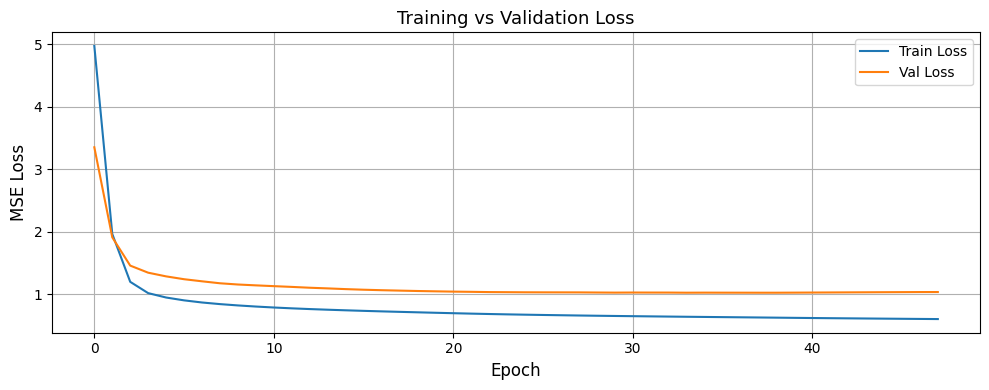

 Loss curve saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/losscurve_lb60_u18_dp0.0_lr1e-04_basinALL.png


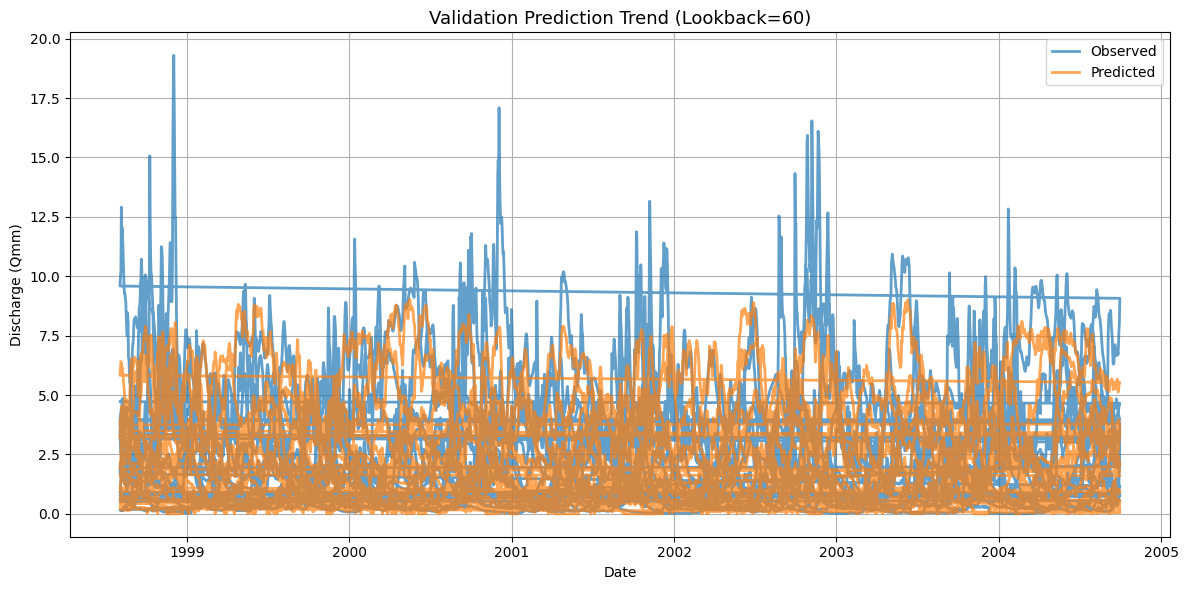

 Validation trend saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_lb60_u18_dp0.0_lr1e-04_basinALL.png
 Validation prediction CSV saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/csv/val_pred_lb60_u18_dp0.0_lr1e-04_basinALL.csv
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[Test] KGE: 0.777, NSE: 0.781, CCC: 0.873


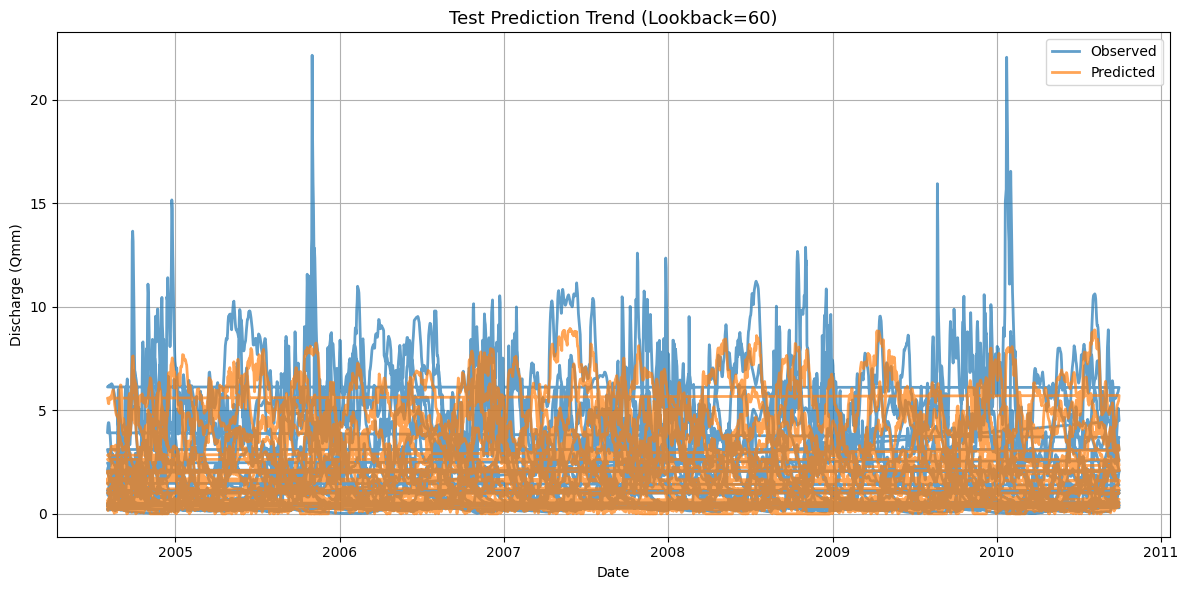

 Test trend saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_lb60_u18_dp0.0_lr1e-04_basinALL.png
 Test prediction CSV saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/csv/test_pred_lb60_u18_dp0.0_lr1e-04_basinALL.csv


In [21]:
# Loss curve
loss_fig_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"losscurve_{run_tag}.png")

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.title("Training vs Validation Loss", fontsize=13)
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(loss_fig_path, dpi=300)
plt.show()
print(f" Loss curve saved to: {loss_fig_path}")

# Trend Chart of Validation Set
trend_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"val_trend_{run_tag}.png")
dates_val = val_std['date'].reset_index(drop=True).iloc[lookback-1 : lookback-1 + len(y_val)]

plt.figure(figsize=(12, 6))
plt.plot(dates_val, y_val, label='Observed', linewidth=2, alpha=0.7)
plt.plot(dates_val, y_val_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel("Date"); plt.ylabel("Discharge (Qmm)")
plt.title(f"Validation Prediction Trend (Lookback={lookback})", fontsize=13)
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(trend_path, dpi=300)
plt.show()
print(f" Validation trend saved to: {trend_path}")

#Save the CSV file of validation set predictions
val_csv_path = os.path.join(GLOBAL_OUTPUT_DIR, "csv", f"val_pred_{run_tag}.csv")
df_val_pred = pd.DataFrame({
    'date': dates_val.values,
    'observed': y_val,
    'predicted': y_val_pred
})
df_val_pred.to_csv(val_csv_path, index=False)
print(f" Validation prediction CSV saved to: {val_csv_path}")



test_metrics = evaluate_model(model, X_test, y_test, name="Test")
y_test_pred = test_metrics["y_pred"]
kge_test = test_metrics["KGE"]
nse_test = test_metrics["NSE"]
ccc_test = test_metrics["CCC"]

# Save Trend Chart of Test Set
trend_path_test = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"test_trend_{run_tag}.png")
dates_te = test_std['date'].reset_index(drop=True).iloc[lookback-1 : lookback-1 + len(y_test)]

plt.figure(figsize=(12, 6))
plt.plot(dates_te, y_test, label='Observed', linewidth=2, alpha=0.7)
plt.plot(dates_te, y_test_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel("Date"); plt.ylabel("Discharge (Qmm)")
plt.title(f"Test Prediction Trend (Lookback={lookback})", fontsize=13)
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(trend_path_test, dpi=300)
plt.show()
print(f" Test trend saved to: {trend_path_test}")

#Save the CSV file of test set predictions
test_csv_path = os.path.join(GLOBAL_OUTPUT_DIR, "csv", f"test_pred_{run_tag}.csv")
df_test_pred = pd.DataFrame({
    'date': dates_te.values,
    'observed': y_test,
    'predicted': y_test_pred
})
df_test_pred.to_csv(test_csv_path, index=False)
print(f" Test prediction CSV saved to: {test_csv_path}")



In [22]:
val_result = evaluate_model(model, X_val, y_val, name="Validation")
test_result = evaluate_model(model, X_test, y_test, name="Test")

1028/1028 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[Validation] KGE: 0.813, NSE: 0.767, CCC: 0.868
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[Test] KGE: 0.777, NSE: 0.781, CCC: 0.873


In [23]:
def save_val_prediction_by_basin(basin_id):
    basin_ids_val = val_std["ID_CABra"].reset_index(drop=True).iloc[LOOKBACK-1 : LOOKBACK-1 + len(y_val)]
    mask = basin_ids_val == basin_id
    plt.figure(figsize=(10, 5))
    plt.plot(dates_val[mask], y_val[mask], label="Observed")
    plt.plot(dates_val[mask], y_val_pred[mask], label="Predicted")
    plt.title(f"Validation Prediction for Basin ID {basin_id}")
    plt.xlabel("Date"); plt.ylabel("Qmm")
    plt.legend(); plt.grid(True); plt.tight_layout()
    fig_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"val_trend_basin{basin_id}_{run_tag}.png")
    plt.savefig(fig_path, dpi=300)
    plt.close()
    print(f"Saved: {fig_path}")


In [24]:
for basin_id in basin_ids:
    save_val_prediction_by_basin(basin_id)

Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin11_lb60_u18_dp0.0_lr1e-04_basinALL.png
Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin21_lb60_u18_dp0.0_lr1e-04_basinALL.png
Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin22_lb60_u18_dp0.0_lr1e-04_basinALL.png
Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin30_lb60_u18_dp0.0_lr1e-04_basinALL.png
Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin31_lb60_u18_dp0.0_lr1e-04_basinALL.png
Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin32_lb60_u18_dp0.0_lr1e-04_basinALL.png
Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin35_lb60_u18_dp0.0_lr1e-04_basinALL.png
Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin37_lb60_u18_dp0.0_lr1e-04_basinALL.png
Saved: /content/

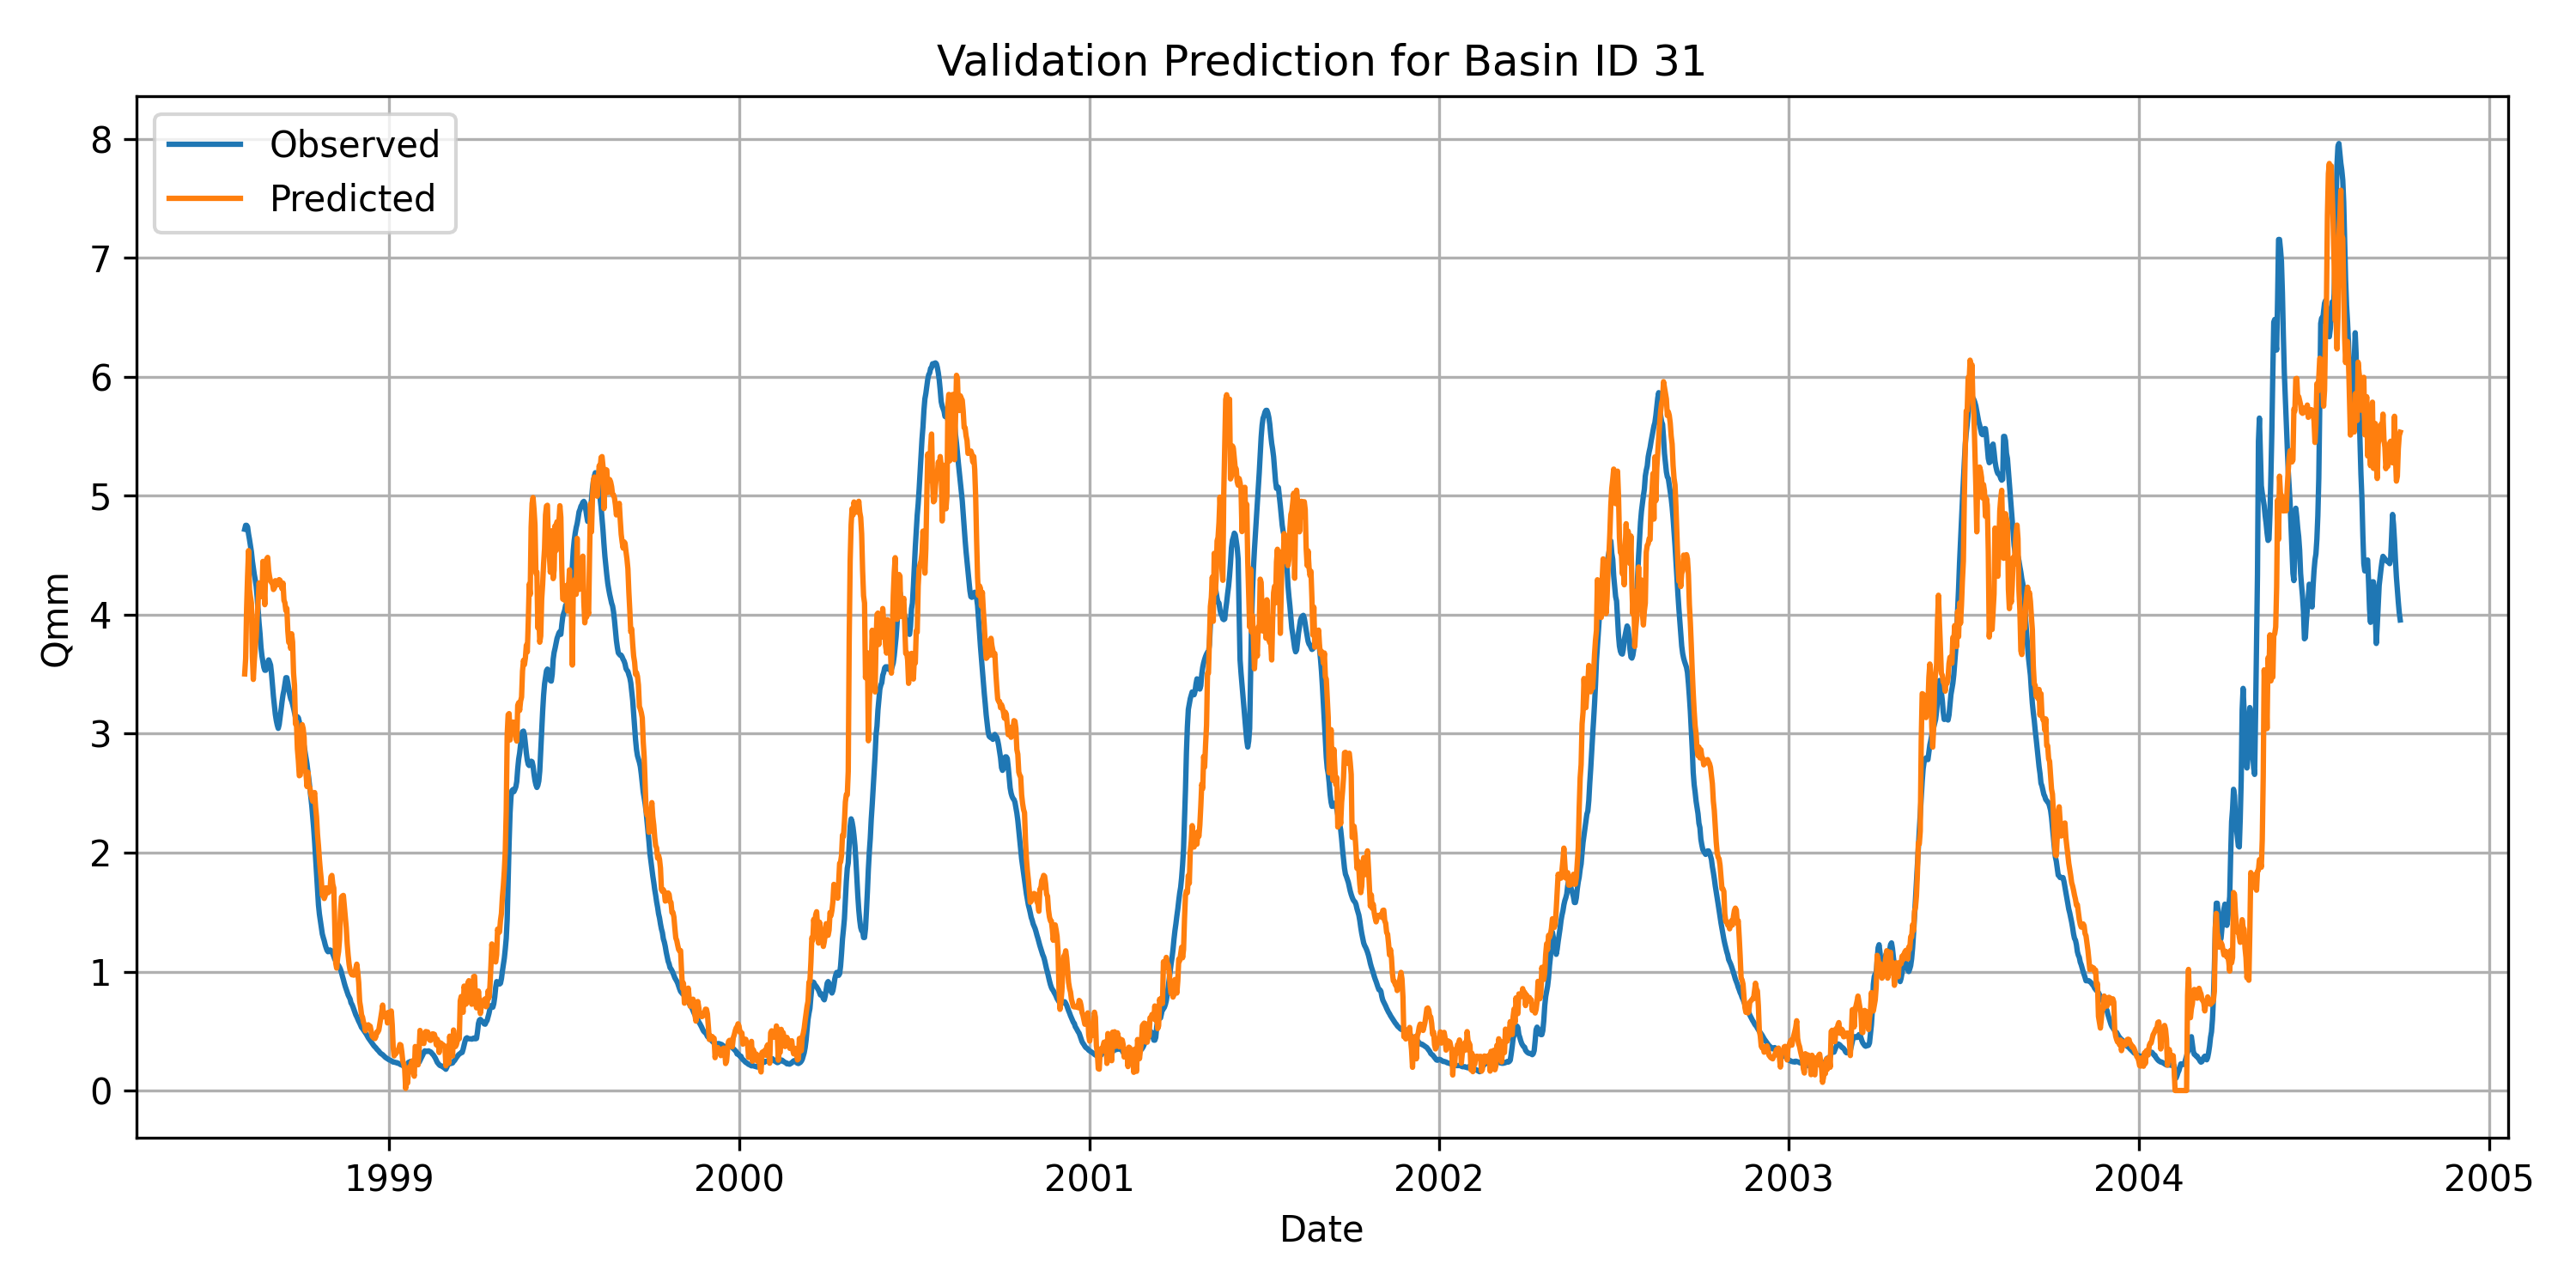

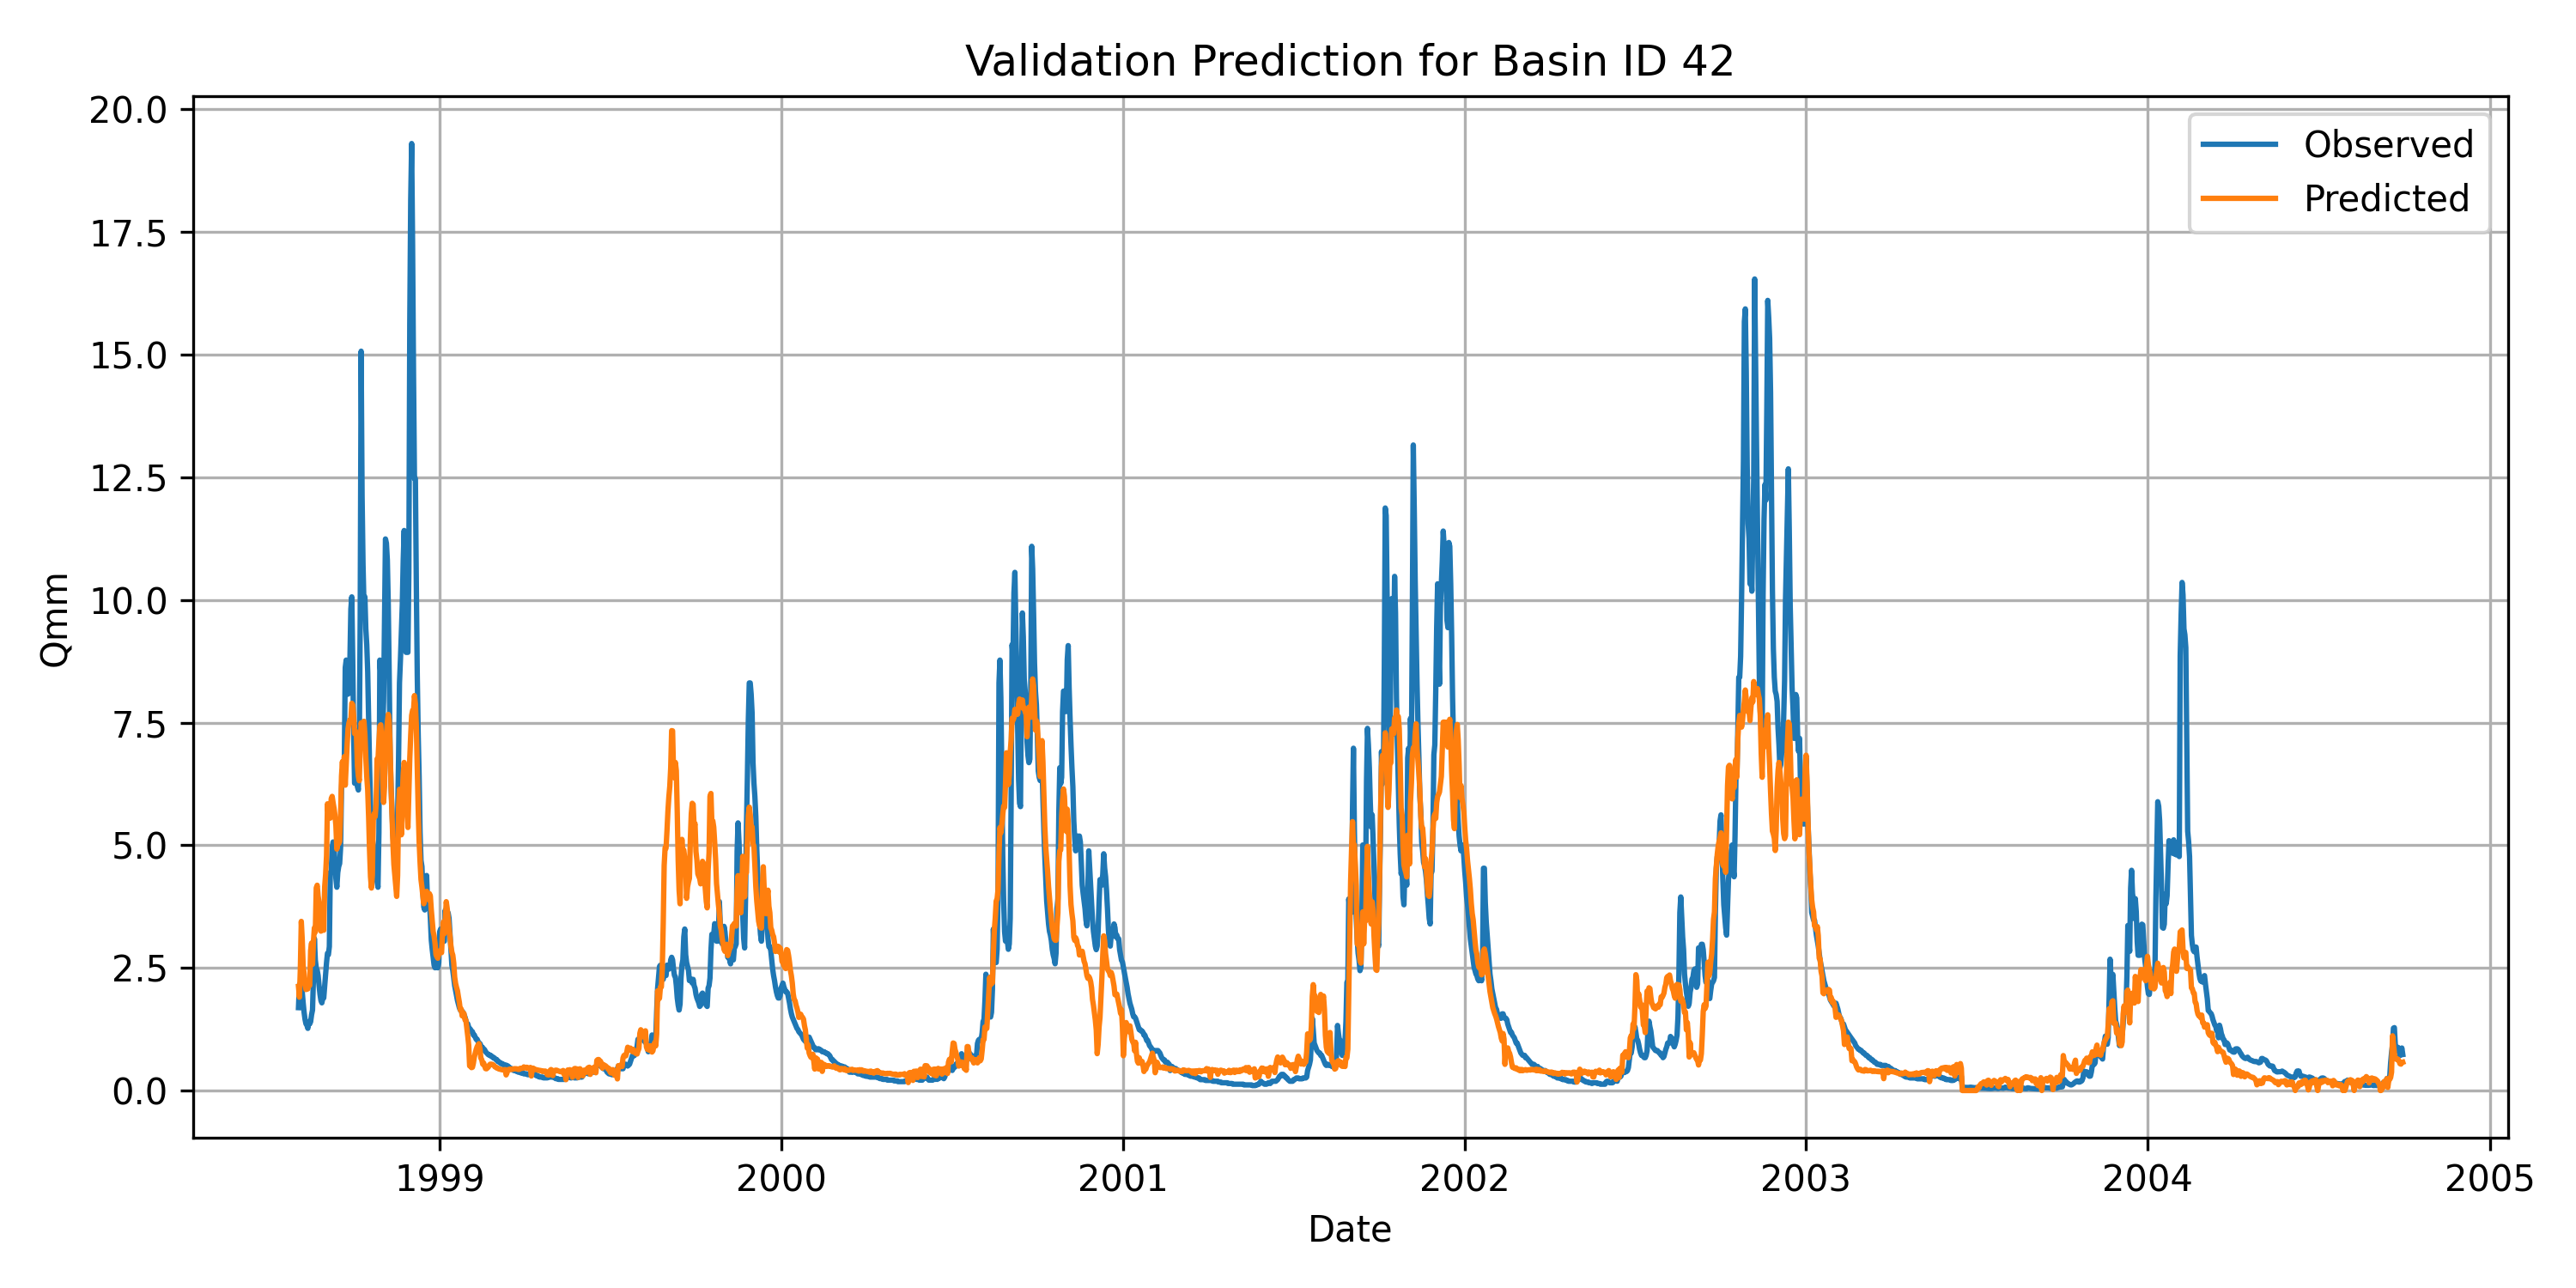

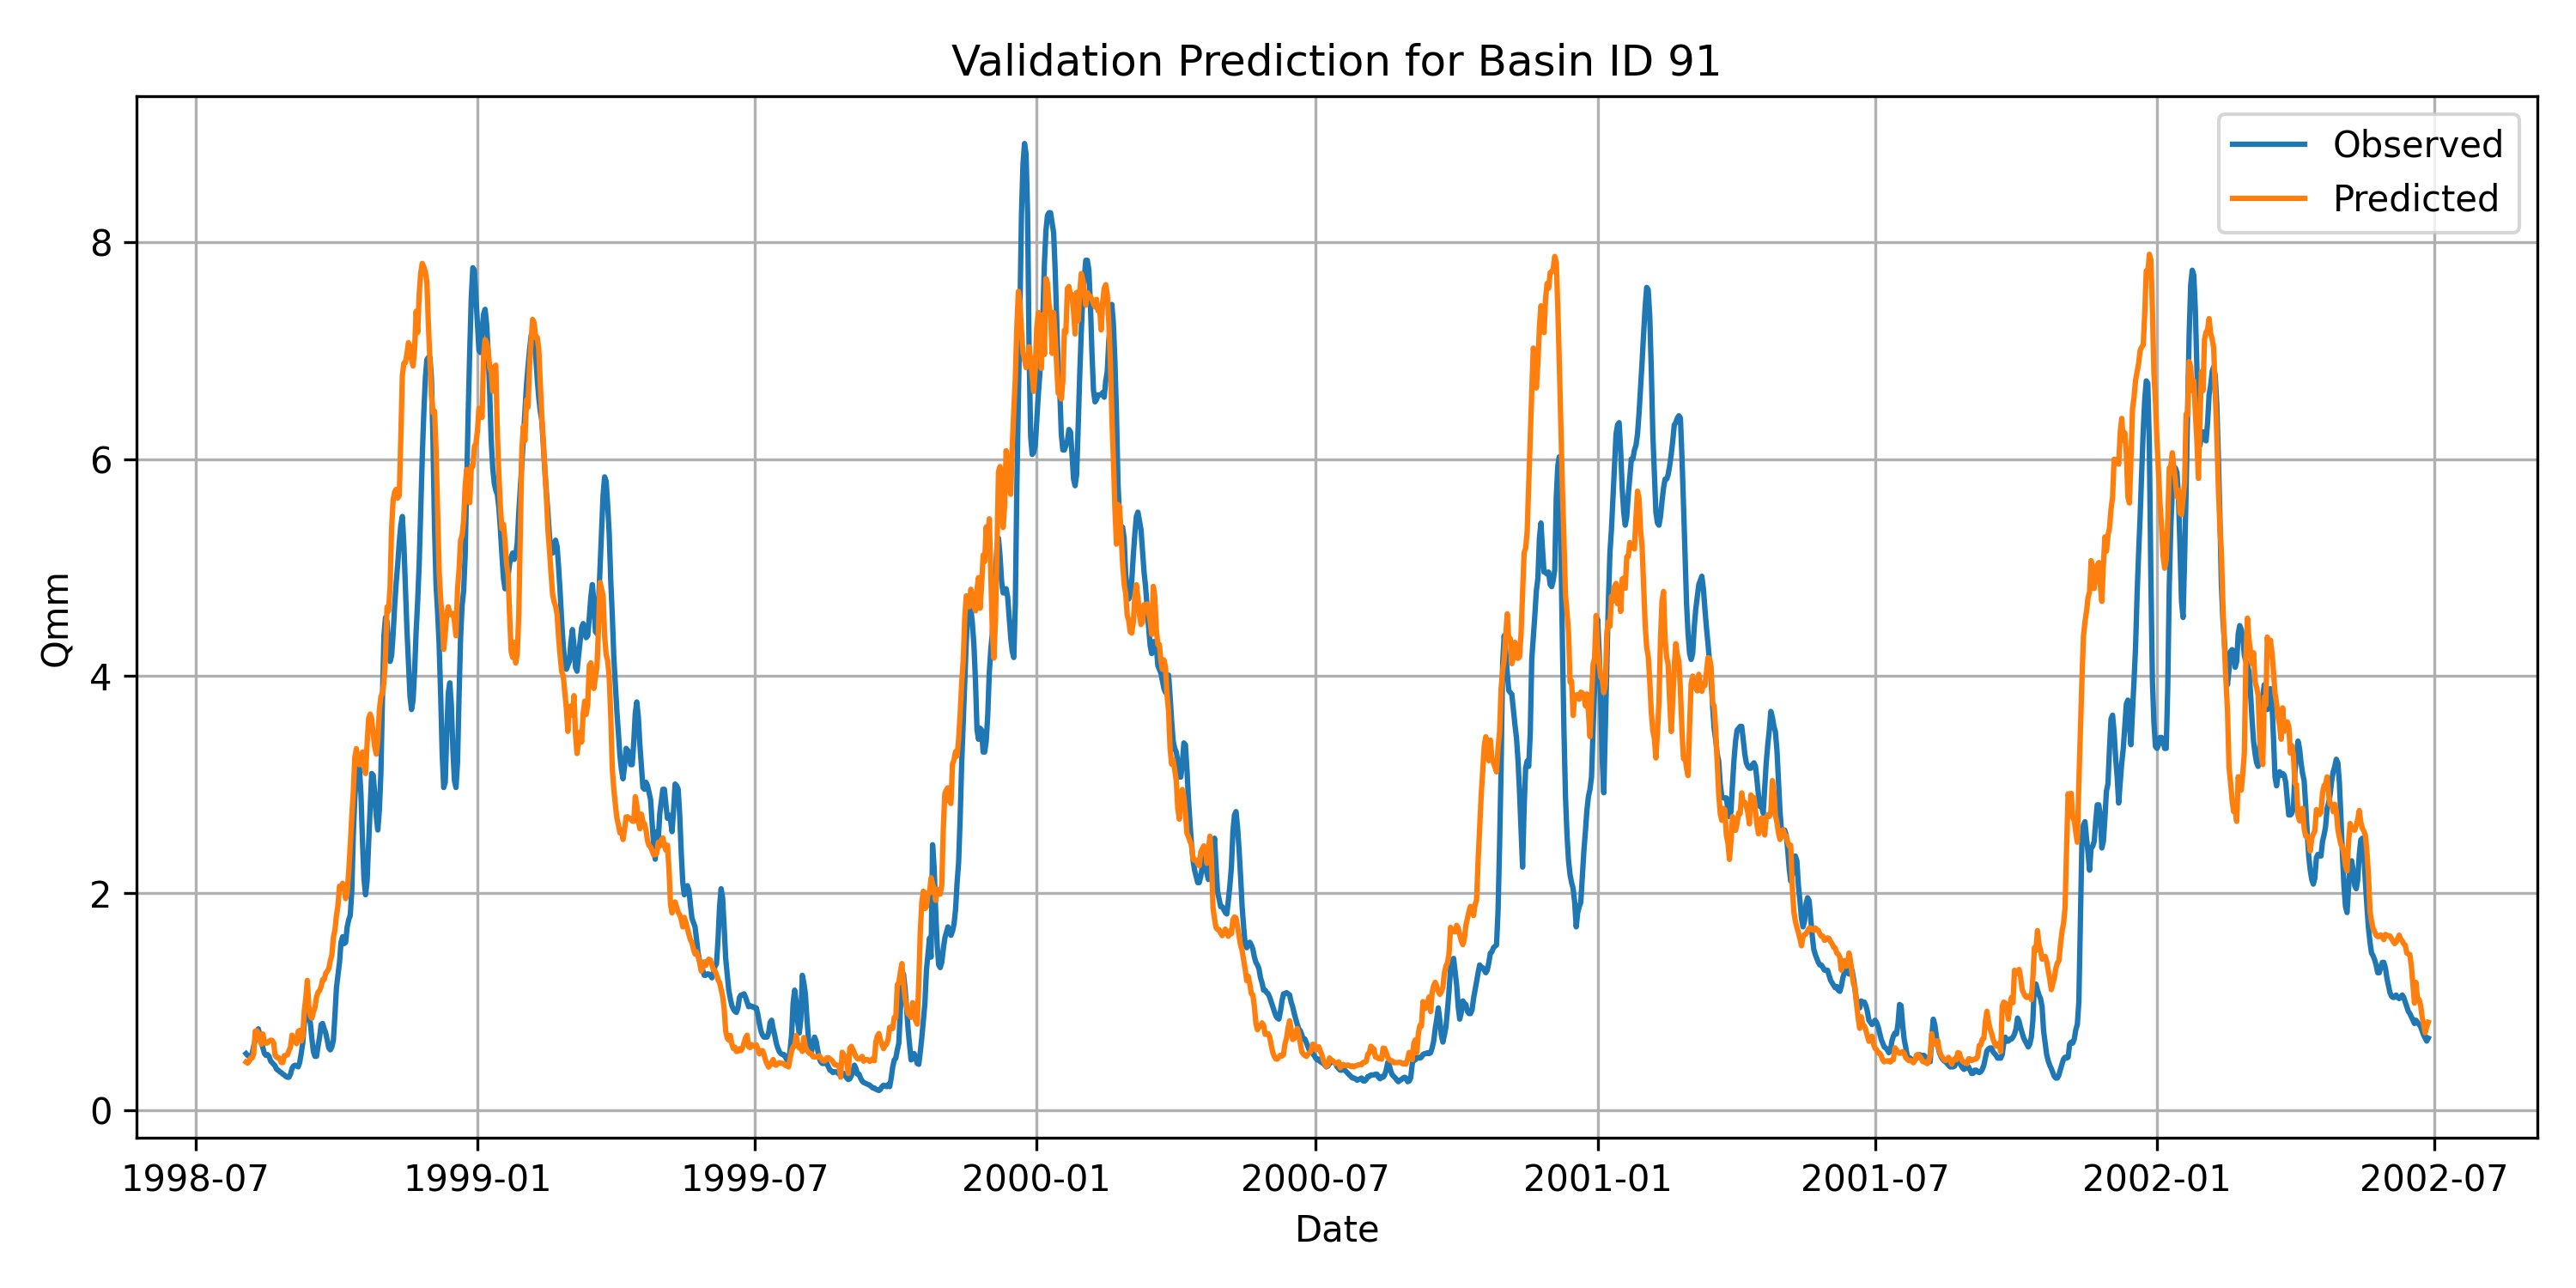

In [25]:
from IPython.display import Image, display

def show_val_plot(basin_id):
    path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"val_trend_basin{basin_id}_{run_tag}.png")
    display(Image(filename=path))

show_val_plot(31)
show_val_plot(42)
show_val_plot(91)

## 2.2 Lookback window

In [26]:
# Evaluation of the Lookback Window
def run_lookback_study(train_std, val_std, target, feature_set,
                       lookbacks=[15, 30, 60, 90, 180, 360, 720],
                       run_tag="lbStudy_dp0.2_lr1e-4"):

    output_prefix = f"lookback_{run_tag}"
    lookback_results = []

    for lb in tqdm(lookbacks, desc="Lookback study"):
        print(f"\nRunning lookback={lb}...")

        #Construction of Sliding Window Sample
        X_tr, y_tr = create_sequences(train_std, feature_set, target, lb)
        X_vl, y_vl = create_sequences(val_std, feature_set, target, lb)
        print(f"Training shape = {X_tr.shape}, Validation shape = {X_vl.shape}")

        #Parameter Settings
        num_feats   = X_tr.shape[2]
        units       = num_feats
        dropout     = 0.2
        lr          = 1e-4
        batch_size  = 64
        num_epochs  = 100

        model = make_model(lb, num_feats, units=units, dp=dropout, lr=lr)

        # Model Naming and Path
        model_name = f"{output_prefix}_{lb}d"
        ckpt_path = os.path.join(GLOBAL_OUTPUT_DIR, "models", f"{model_name}.weights.h5")
        loss_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"{model_name}_loss.png")
        history_path = os.path.join(GLOBAL_OUTPUT_DIR, "histories", f"{model_name}_history.json")

        # Training Callback Settings 
        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        ckpt = ModelCheckpoint(filepath=ckpt_path, monitor="val_loss", save_best_only=True, save_weights_only=True)

        #Model Training
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_vl, y_vl),
            epochs=num_epochs,
            batch_size=batch_size,
            callbacks=[es, ckpt],
            verbose=0
        )

        with open(history_path, 'w') as f:
            json.dump(history.history, f)
        print(f"History saved to: {history_path}")

        # Model Evaluation 
        metrics = evaluate_model(model, X_vl, y_vl, name=f"Val_LB{lb}")
        y_pred = metrics["y_pred"]
        kge_val = metrics["KGE"]
        nse_val = metrics["NSE"]
        ccc_val = metrics["CCC"]

        print("Pred:", np.round(y_pred[:5], 3))
        print("True:", np.round(y_vl[:5], 3))

    
        plt.figure()
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss Curve - LB={lb}")
        plt.legend(); plt.grid(True)
        plt.savefig(loss_path, dpi=150); plt.close()
        print(f"Loss curve saved to {loss_path}")

        if np.isnan(kge_val) or kge_val < 0.6:
            print(f"Warning: KGE is low or invalid at LB={lb} → KGE={kge_val:.3f}")
        if np.isnan(nse_val):
            print(f"Warning: NSE is NaN at LB={lb}")

        #save
        lookback_results.append({
            'model_name': model_name,
            'lookback': lb,
            'units': units,
            'dropout': dropout,
            'lr': lr,
            'batch_size': batch_size,
            'KGE': kge_val,
            'NSE': nse_val,
            'CCC': ccc_val,
            'note': 'baseline run'
        })

 
    df_lookback = pd.DataFrame(lookback_results)
    csv_path = os.path.join(GLOBAL_OUTPUT_DIR, "metrics", f"{output_prefix}_summary.csv")
    df_lookback.to_csv(csv_path, index=False)
    print(f"Summary CSV saved to: {csv_path}")

    # Save Indicator Trend Chart
    fig_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"{output_prefix}_metric_plot.png")
    plt.figure(figsize=(8, 5))
    plt.plot(df_lookback['lookback'], df_lookback['KGE'], marker='o', label='KGE', color='#4da6ff')
    plt.plot(df_lookback['lookback'], df_lookback['NSE'], marker='s', label='NSE', color='#ffa726')
    plt.plot(df_lookback['lookback'], df_lookback['CCC'], marker='^', label='CCC', color='#66bb6a')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlabel("Lookback (days)", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.title("KGE, NSE & CCC vs Lookback", fontsize=13, weight='bold')
    plt.legend()
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Metric plot saved to: {fig_path}")

    return df_lookback

In [27]:
run_tag = "lbStudy_dp0.2_lr1e-4"
df_lb_result = run_lookback_study(
    train_std=train_std,
    val_std=val_std,
    target="Qmm",
    feature_set=selected_features,
    lookbacks=[15, 30, 60, 90, 180, 360, 720],
    run_tag=run_tag
)


Lookback study:   0%|          | 0/7 [00:00<?, ?it/s]


Running lookback=15...
Training shape = (98596, 15, 18), Validation shape = (33751, 15, 18)
History saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/histories/lookback_lbStudy_dp0.2_lr1e-4_15d_history.json
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Lookback study:  14%|█▍        | 1/7 [07:09<42:58, 429.71s/it]

[Val_LB15] KGE: 0.671, NSE: 0.616, CCC: 0.757
Pred: [4.23  4.475 4.543 4.606 4.811]
True: [3.443 3.507 3.368 3.182 3.145]
Loss curve saved to /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_lbStudy_dp0.2_lr1e-4_15d_loss.png

Running lookback=30...
Training shape = (98581, 30, 18), Validation shape = (33736, 30, 18)
History saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/histories/lookback_lbStudy_dp0.2_lr1e-4_30d_history.json
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Lookback study:  29%|██▊       | 2/7 [15:15<38:33, 462.70s/it]

[Val_LB30] KGE: 0.739, NSE: 0.697, CCC: 0.817
Pred: [3.015 3.257 3.089 2.933 2.723]
True: [3.393 3.443 3.494 3.268 3.084]
Loss curve saved to /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_lbStudy_dp0.2_lr1e-4_30d_loss.png

Running lookback=60...
Training shape = (98551, 60, 18), Validation shape = (33706, 60, 18)
History saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/histories/lookback_lbStudy_dp0.2_lr1e-4_60d_history.json
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Lookback study:  43%|████▎     | 3/7 [20:23<26:07, 391.88s/it]

[Val_LB60] KGE: 0.783, NSE: 0.769, CCC: 0.865
Pred: [2.24  2.54  2.603 2.618 2.552]
True: [1.669 1.622 1.989 2.089 2.231]
Loss curve saved to /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_lbStudy_dp0.2_lr1e-4_60d_loss.png

Running lookback=90...
Training shape = (98521, 90, 18), Validation shape = (33676, 90, 18)
History saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/histories/lookback_lbStudy_dp0.2_lr1e-4_90d_history.json
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


Lookback study:  57%|█████▋    | 4/7 [30:13<23:31, 470.39s/it]

[Val_LB90] KGE: 0.808, NSE: 0.794, CCC: 0.882
Pred: [1.746 1.666 1.541 1.542 1.558]
True: [1.374 1.41  1.447 1.392 1.437]
Loss curve saved to /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_lbStudy_dp0.2_lr1e-4_90d_loss.png

Running lookback=180...
Training shape = (98431, 180, 18), Validation shape = (33586, 180, 18)
History saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/histories/lookback_lbStudy_dp0.2_lr1e-4_180d_history.json
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


Lookback study:  71%|███████▏  | 5/7 [35:51<14:04, 422.50s/it]

[Val_LB180] KGE: 0.806, NSE: 0.792, CCC: 0.881
Pred: [3.108 2.827 2.604 2.369 2.213]
True: [2.761 3.06  3.182 3.072 2.844]
Loss curve saved to /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_lbStudy_dp0.2_lr1e-4_180d_loss.png

Running lookback=360...
Training shape = (98251, 360, 18), Validation shape = (33406, 360, 18)
History saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/histories/lookback_lbStudy_dp0.2_lr1e-4_360d_history.json
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


Lookback study:  86%|████████▌ | 6/7 [49:19<09:13, 553.53s/it]

[Val_LB360] KGE: 0.790, NSE: 0.797, CCC: 0.883
Pred: [5.367 5.587 5.784 5.976 6.25 ]
True: [5.986 6.183 5.986 5.925 6.168]
Loss curve saved to /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_lbStudy_dp0.2_lr1e-4_360d_loss.png

Running lookback=720...
Training shape = (97891, 720, 18), Validation shape = (33046, 720, 18)
History saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/histories/lookback_lbStudy_dp0.2_lr1e-4_720d_history.json
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step


Lookback study: 100%|██████████| 7/7 [1:09:34<00:00, 596.36s/it]

[Val_LB720] KGE: 0.831, NSE: 0.803, CCC: 0.889
Pred: [5.772 5.488 5.205 5.112 5.241]
True: [6.214 6.016 5.805 5.436 5.261]
Loss curve saved to /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_lbStudy_dp0.2_lr1e-4_720d_loss.png
Summary CSV saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/metrics/lookback_lbStudy_dp0.2_lr1e-4_summary.csv


Metric plot saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_lbStudy_dp0.2_lr1e-4_metric_plot.png


 Best Lookback Found: 720 days


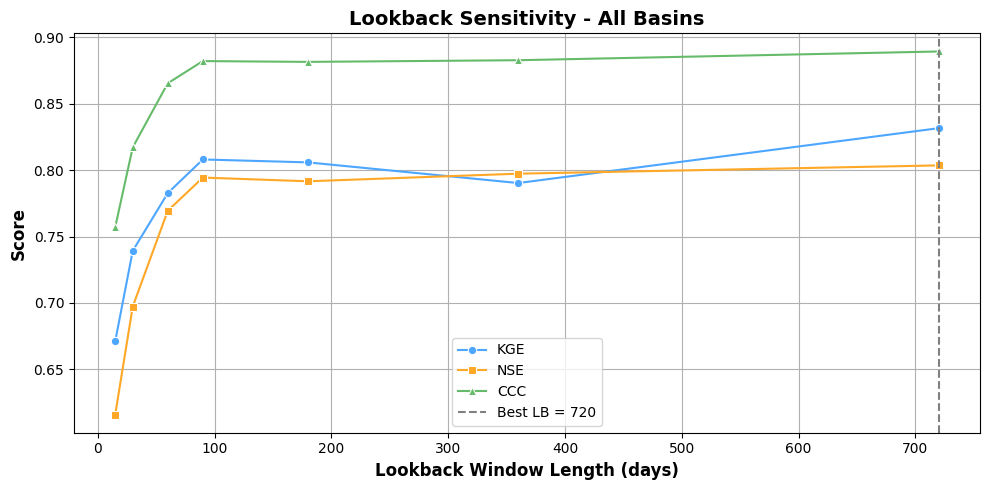

 Sensitivity curve with CCC saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_sensitivity_best_line_with_CCC.png


In [28]:
# Identify the best lookback (based on the maximum value of KGE)
best_lb = int(df_lb_result.loc[df_lb_result['KGE'].idxmax(), 'lookback'])
print(f" Best Lookback Found: {best_lb} days")

#  Plot the sensitivity curves of KGE / NSE / CCC versus Lookback
plt.figure(figsize=(10, 5))

sns.lineplot(x="lookback", y="KGE", data=df_lb_result,
             marker="o", label="KGE", color="#4da6ff")
sns.lineplot(x="lookback", y="NSE", data=df_lb_result,
             marker="s", label="NSE", color="#ffa726")
sns.lineplot(x="lookback", y="CCC", data=df_lb_result,
             marker="^", label="CCC", color="#66bb6a")  

plt.axvline(x=best_lb, color="gray", linestyle="--", label=f"Best LB = {best_lb}")
plt.xlabel("Lookback Window Length (days)", fontsize=12, fontweight="bold")
plt.ylabel("Score", fontsize=12, fontweight="bold")
plt.title("Lookback Sensitivity - All Basins", fontsize=14, fontweight="bold")
plt.grid(True); plt.legend(); plt.tight_layout()

fig_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", "lookback_sensitivity_best_line_with_CCC.png")
plt.savefig(fig_path, dpi=300)
plt.show()
print(f" Sensitivity curve with CCC saved to: {fig_path}")

Although the highest KGE was achieved at a lookback window of 720 days, the performance gain beyond 90 days was minimal and exhibited diminishing returns. Moreover, after 180 days, the evaluation metrics showed slight fluctuations, indicating reduced model stability. Therefore, a lookback of 90 days was selected as the optimal configuration to balance predictive accuracy and model generalization.

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step


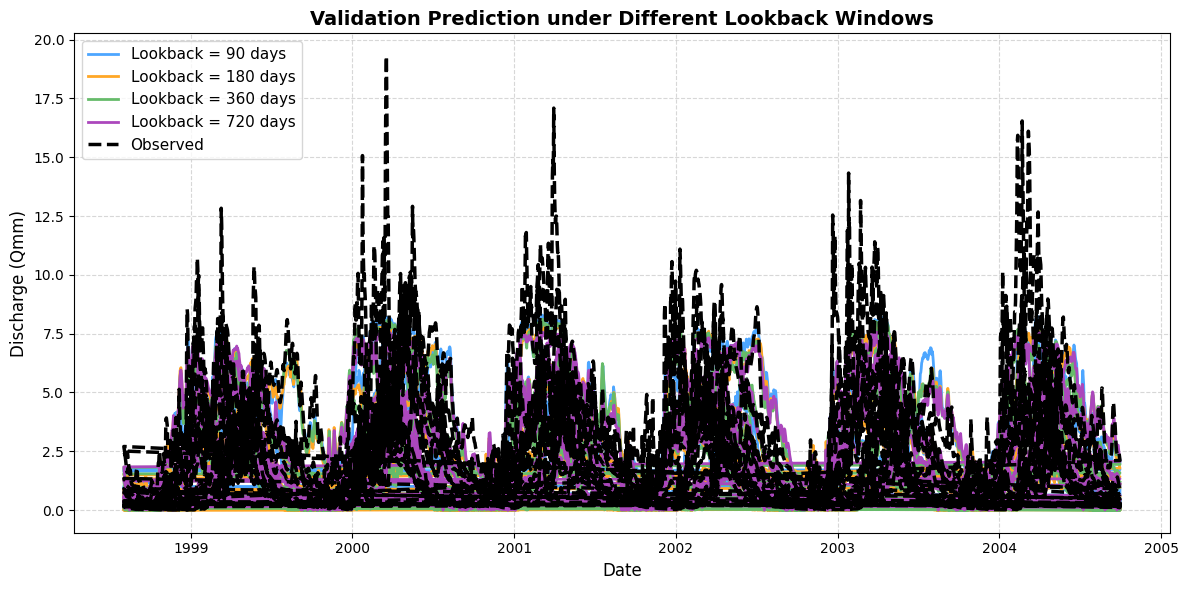

 Lookback trend comparison saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_prediction_trend_lbStudy_dp0.2_lr1e-4.png


In [34]:
#  Compare the predicted trends of different windows
# === Lookback Prediction Trend Comparison (60, 90, 180 days) ===

run_tag = "lbStudy_dp0.2_lr1e-4"
selected_lookbacks = [90, 180, 360, 720]
colors = ['#4da6ff', '#ffa726', '#66bb6a', '#ab47bc']
full_dates = val_std['date'].reset_index(drop=True)

plt.figure(figsize=(12, 6))

for i, lb in enumerate(selected_lookbacks):
    #Constructing the validation set input
    X_vl_lb, y_vl_lb = create_sequences(val_std, selected_features, TARGET, lb)
    dates_val_lb = pd.to_datetime(full_dates.iloc[lb-1 : lb-1 + len(y_vl_lb)]).values

    #Load the training model corresponding to the lookback
    model_path = os.path.join(
        GLOBAL_OUTPUT_DIR,
        "models",
        f"lookback_{run_tag}_{lb}d.weights.h5"
    )
    model = make_model(lb, len(selected_features),
                       units=len(selected_features),
                       dp=0.2, lr=1e-4)
    model.load_weights(model_path)

    # predict
    y_pred_lb = model.predict(X_vl_lb).flatten()
    plt.plot(dates_val_lb, y_pred_lb,
             label=f'Lookback = {lb} days',
             color=colors[i],
             linewidth=2)

# Add the observed values (aligned with lb = 90 as the reference point)
X_90, y_obs = create_sequences(val_std, selected_features, TARGET, 90)
dates_obs = pd.to_datetime(full_dates.iloc[90-1 : 90-1 + len(y_obs)]).values
plt.plot(dates_obs, y_obs, 'k--', linewidth=2.5, label='Observed')

#Image Settings
plt.xlabel('Date', fontsize=12)
plt.ylabel('Discharge (Qmm)', fontsize=12)
plt.title("Validation Prediction under Different Lookback Windows", fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.tight_layout()

#save
trend_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"lookback_prediction_trend_{run_tag}.png")
plt.savefig(trend_path, dpi=300)
plt.show()
print(f" Lookback trend comparison saved to: {trend_path}")



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step


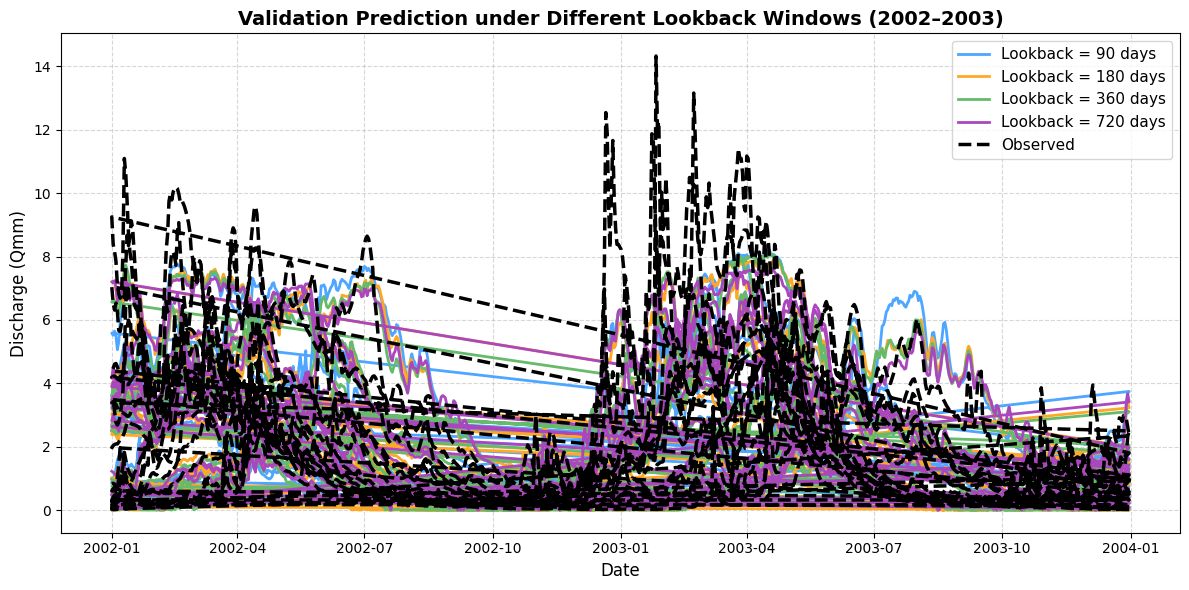

Zoomed trend comparison saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/lookback_prediction_trend_zoom_2002_2003.png


In [35]:
#Set the visible time period 
start_date = pd.to_datetime("2002-01-01")
end_date = pd.to_datetime("2003-12-31")

# plot
plt.figure(figsize=(12, 6))

for i, lb in enumerate(selected_lookbacks):
    X_vl_lb, y_vl_lb = create_sequences(val_std, selected_features, TARGET, lb)
    dates_val_lb = pd.to_datetime(full_dates.iloc[lb-1 : lb-1 + len(y_vl_lb)]).values

    model_path = os.path.join(
        GLOBAL_OUTPUT_DIR, "models", f"lookback_{run_tag}_{lb}d.weights.h5"
    )
    model = make_model(lb, len(selected_features), units=len(selected_features), dp=0.2, lr=1e-4)
    model.load_weights(model_path)

    y_pred_lb = model.predict(X_vl_lb).flatten()


    mask = (dates_val_lb >= start_date) & (dates_val_lb <= end_date)
    plt.plot(dates_val_lb[mask], y_pred_lb[mask],
             label=f'Lookback = {lb} days', color=colors[i], linewidth=2)


X_90, y_obs = create_sequences(val_std, selected_features, TARGET, 90)
dates_obs = pd.to_datetime(full_dates.iloc[90-1 : 90-1 + len(y_obs)]).values
mask_obs = (dates_obs >= start_date) & (dates_obs <= end_date)
plt.plot(dates_obs[mask_obs], y_obs[mask_obs],
         'k--', linewidth=2.5, label='Observed')


plt.xlabel('Date', fontsize=12)
plt.ylabel('Discharge (Qmm)', fontsize=12)
plt.title("Validation Prediction under Different Lookback Windows (2002–2003)", fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.tight_layout()

trend_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"lookback_prediction_trend_zoom_2002_2003.png")
plt.savefig(trend_path, dpi=300)
plt.show()

print(f"Zoomed trend comparison saved to: {trend_path}")


 1/68 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


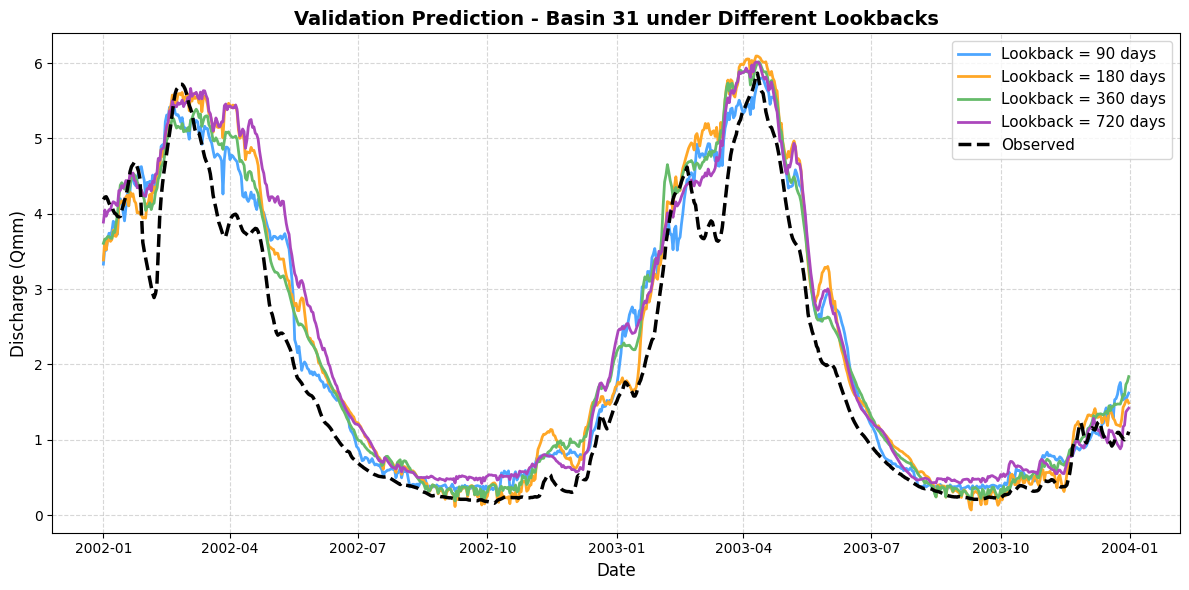

 Saved single-basin trend comparison to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin31_lookback_compare_zoom_2002_2003.png


In [36]:
# Select catchment 31 from 2002.1 to 2003.12

basin_id = 31  
run_tag = "lbStudy_dp0.2_lr1e-4"
selected_lookbacks = [90, 180, 360, 720]
colors = ['#4da6ff', '#ffa726', '#66bb6a', '#ab47bc']
full_dates = val_std['date'].reset_index(drop=True)

start_date = pd.to_datetime("2002-01-01")
end_date = pd.to_datetime("2003-12-31")

plt.figure(figsize=(12, 6))

for i, lb in enumerate(selected_lookbacks):

    val_basin = val_std[val_std["ID_CABra"] == basin_id].copy()
    X_val_basin, y_val_basin = create_sequences(val_basin, selected_features, TARGET, lb)
    dates_val_basin = pd.to_datetime(val_basin["date"].reset_index(drop=True).iloc[lb-1 : lb-1 + len(y_val_basin)]).values

   
    model_path = os.path.join(
        GLOBAL_OUTPUT_DIR, "models", f"lookback_{run_tag}_{lb}d.weights.h5"
    )
    model = make_model(lb, len(selected_features), units=len(selected_features), dp=0.2, lr=1e-4)
    model.load_weights(model_path)

    
    y_pred_basin = model.predict(X_val_basin).flatten()

    
    mask = (dates_val_basin >= start_date) & (dates_val_basin <= end_date)
    plt.plot(dates_val_basin[mask], y_pred_basin[mask],
             label=f'Lookback = {lb} days', color=colors[i], linewidth=2)

# Plot the observed values (aligned with a 90-day window)
val_basin = val_std[val_std["ID_CABra"] == basin_id].copy()
X_90, y_obs = create_sequences(val_basin, selected_features, TARGET, 90)
dates_obs = pd.to_datetime(val_basin["date"].reset_index(drop=True).iloc[90-1 : 90-1 + len(y_obs)]).values
mask_obs = (dates_obs >= start_date) & (dates_obs <= end_date)
plt.plot(dates_obs[mask_obs], y_obs[mask_obs],
         'k--', linewidth=2.5, label='Observed')

plt.xlabel("Date", fontsize=12)
plt.ylabel("Discharge (Qmm)", fontsize=12)
plt.title(f"Validation Prediction - Basin {basin_id} under Different Lookbacks", fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.tight_layout()

# save
fig_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"val_trend_basin{basin_id}_lookback_compare_zoom_2002_2003.png")
plt.savefig(fig_path, dpi=300)
plt.show()

print(f" Saved single-basin trend comparison to: {fig_path}")


 1/68 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


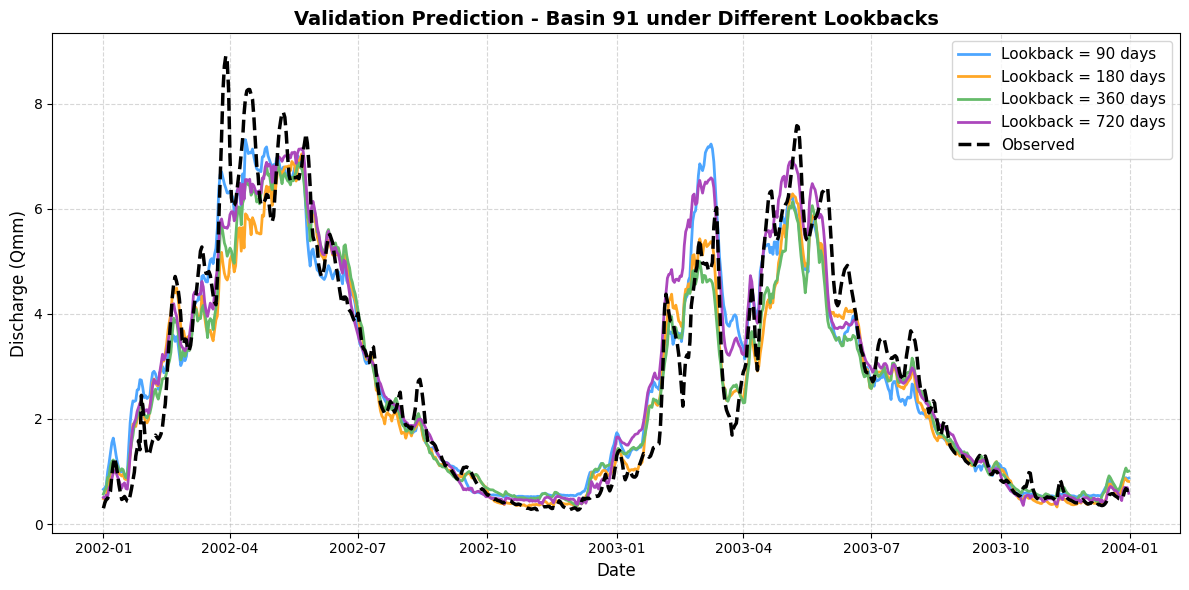

 Saved single-basin trend comparison to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin91_lookback_compare_zoom_2002_2003.png


In [37]:
basin_id = 91  
run_tag = "lbStudy_dp0.2_lr1e-4"
selected_lookbacks = [90, 180, 360, 720]
colors = ['#4da6ff', '#ffa726', '#66bb6a', '#ab47bc']
full_dates = val_std['date'].reset_index(drop=True)

start_date = pd.to_datetime("2002-01-01")
end_date = pd.to_datetime("2003-12-31")

plt.figure(figsize=(12, 6))

for i, lb in enumerate(selected_lookbacks):

    val_basin = val_std[val_std["ID_CABra"] == basin_id].copy()
    X_val_basin, y_val_basin = create_sequences(val_basin, selected_features, TARGET, lb)
    dates_val_basin = pd.to_datetime(val_basin["date"].reset_index(drop=True).iloc[lb-1 : lb-1 + len(y_val_basin)]).values

   
    model_path = os.path.join(
        GLOBAL_OUTPUT_DIR, "models", f"lookback_{run_tag}_{lb}d.weights.h5"
    )
    model = make_model(lb, len(selected_features), units=len(selected_features), dp=0.2, lr=1e-4)
    model.load_weights(model_path)

    
    y_pred_basin = model.predict(X_val_basin).flatten()

    
    mask = (dates_val_basin >= start_date) & (dates_val_basin <= end_date)
    plt.plot(dates_val_basin[mask], y_pred_basin[mask],
             label=f'Lookback = {lb} days', color=colors[i], linewidth=2)


val_basin = val_std[val_std["ID_CABra"] == basin_id].copy()
X_90, y_obs = create_sequences(val_basin, selected_features, TARGET, 90)
dates_obs = pd.to_datetime(val_basin["date"].reset_index(drop=True).iloc[90-1 : 90-1 + len(y_obs)]).values
mask_obs = (dates_obs >= start_date) & (dates_obs <= end_date)
plt.plot(dates_obs[mask_obs], y_obs[mask_obs],
         'k--', linewidth=2.5, label='Observed')


plt.xlabel("Date", fontsize=12)
plt.ylabel("Discharge (Qmm)", fontsize=12)
plt.title(f"Validation Prediction - Basin {basin_id} under Different Lookbacks", fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.tight_layout()

fig_path = os.path.join(GLOBAL_OUTPUT_DIR, "plots", f"val_trend_basin{basin_id}_lookback_compare_zoom_2002_2003.png")
plt.savefig(fig_path, dpi=300)
plt.show()

print(f" Saved single-basin trend comparison to: {fig_path}")


As shown in Figure , longer lookback windows (360d, 720d) lead to smoother predictions, but with delayed peak responses and underestimation of rising limbs. The 90-day model aligns closely with observed peaks and troughs, while the 180-day model performs similarly with slightly reduced reactivity. These differences validate the choice of 90 days as the optimal configuration from both quantitative and temporal alignment perspectives.

## 2.3 Gridsearch

In [39]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#Parameter Settings 
LOOKBACK = 90
run_tag = f"gridsearch_lb{LOOKBACK}"
repeat_times = 3

#Create Sliding Window Samples
X_tr_lb, y_tr_lb = create_sequences(train_std, ALL_FEATURES, TARGET, LOOKBACK)
X_vl_lb, y_vl_lb = create_sequences(val_std, ALL_FEATURES, TARGET, LOOKBACK)

best = {'mean_KGE': -np.inf}
best_ckpt = os.path.join(GLOBAL_OUTPUT_DIR, "models", f"best_{run_tag}.weights.h5")

gridsearch_results = []

#  Grid Search Loop 
for units in tqdm([18, 24, 36, 48], desc="Grid Search - units"):
    for lr in [1e-3, 5e-4, 1e-4]:
        for dp in [0.0, 0.1, 0.2]:
            kge_list, nse_list, ccc_list = [], [], []

            for repeat in range(repeat_times):
                model = make_model(LOOKBACK, len(ALL_FEATURES), units, dp, lr)

                model_name = f"{run_tag}_u{units}_lr{lr}_dp{dp}_r{repeat}"
                model_path = os.path.join(GLOBAL_OUTPUT_DIR, "models", f"{model_name}.weights.h5")
                history_path = os.path.join(GLOBAL_OUTPUT_DIR, "histories", f"{model_name}_history.json")

                
                es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                ck = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)

               
                history = model.fit(
                    X_tr_lb, y_tr_lb,
                    validation_data=(X_vl_lb, y_vl_lb),
                    epochs=30,
                    batch_size=64,
                    callbacks=[es, ck],
                    verbose=0
                )

                with open(history_path, 'w') as f:
                    json.dump(history.history, f)

                model.load_weights(model_path)
                y_pred = model.predict(X_vl_lb).flatten()

                kge_val = float(np.atleast_1d(he.evaluator(he.kge, y_pred, y_vl_lb)).flatten()[0])
                nse_val = float(np.atleast_1d(he.evaluator(he.nse, y_pred, y_vl_lb)).flatten()[0])
                ccc_val = float(concordance_correlation_coefficient(y_vl_lb, y_pred))

                kge_list.append(kge_val)
                nse_list.append(nse_val)
                ccc_list.append(ccc_val)

 
            mean_kge, std_kge = np.mean(kge_list), np.std(kge_list)
            mean_nse, std_nse = np.mean(nse_list), np.std(nse_list)
            mean_ccc, std_ccc = np.mean(ccc_list), np.std(ccc_list)

            print(f"units={units}, lr={lr}, dp={dp} → KGE={mean_kge:.3f}, CCC={mean_ccc:.3f}")

            gridsearch_results.append({
                'lookback': LOOKBACK,
                'units': units,
                'lr': lr,
                'dropout': dp,
                'mean_KGE': mean_kge,
                'std_KGE': std_kge,
                'mean_NSE': mean_nse,
                'std_NSE': std_nse,
                'mean_CCC': mean_ccc,
                'std_CCC': std_ccc
            })

            # Update the optimal model 
            if mean_kge > best['mean_KGE']:
                best.update({
                    'lookback': LOOKBACK,
                    'units': units,
                    'lr': lr,
                    'dropout': dp,
                    'mean_KGE': mean_kge,
                    'std_KGE': std_kge,
                    'mean_NSE': mean_nse,
                    'std_NSE': std_nse,
                    'mean_CCC': mean_ccc,
                    'std_CCC': std_ccc
                })
                shutil.copy(model_path, best_ckpt)

#Output the optimal combination.
print("\n Best configuration found:")
for k, v in best.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

#save
df_gridsearch = pd.DataFrame(gridsearch_results)
csv_path = os.path.join(GLOBAL_OUTPUT_DIR, "metrics", f"{run_tag}_summary.csv")
df_gridsearch.to_csv(csv_path, index=False)
print(f"\n Grid search results saved to: {csv_path}")

Grid Search - units:   0%|          | 0/4 [00:00<?, ?it/s]

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=18, lr=0.001, dp=0.0 → KGE=0.845, CCC=0.892
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=18, lr=0.001, dp=0.1 → KGE=0.826, CCC=0.887
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=18, lr=0.001, dp=0.2 → KGE=0.819, CCC=0.887
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
units=18, lr=0.0005, dp=0.0 → KGE=0.846, CCC=0.890
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=18, lr=0.0005, dp=0.1 → KGE=0.822, CCC=0.888
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━

Grid Search - units:  25%|██▌       | 1/4 [1:18:11<3:54:34, 4691.60s/it]

units=18, lr=0.0001, dp=0.2 → KGE=0.813, CCC=0.886
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=24, lr=0.001, dp=0.0 → KGE=0.865, CCC=0.895
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=24, lr=0.001, dp=0.1 → KGE=0.836, CCC=0.890
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=24, lr=0.001, dp=0.2 → KGE=0.823, CCC=0.888
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=24, lr=0.0005, dp=0.0 → KGE=0.843, CCC=0.891
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=24, lr=0.0005, dp=0.1 → KGE=0.838, CCC=0.892
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053

Grid Search - units:  50%|█████     | 2/4 [2:29:03<2:27:46, 4433.02s/it]

units=24, lr=0.0001, dp=0.2 → KGE=0.824, CCC=0.887
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
units=36, lr=0.001, dp=0.0 → KGE=0.837, CCC=0.891
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=36, lr=0.001, dp=0.1 → KGE=0.839, CCC=0.889
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=36, lr=0.001, dp=0.2 → KGE=0.829, CCC=0.890
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
units=36, lr=0.0005, dp=0.0 → KGE=0.845, CCC=0.894
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=36, lr=0.0005, dp=0.1 → KGE=0.840, CCC=0.893
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053

Grid Search - units:  75%|███████▌  | 3/4 [3:29:11<1:07:36, 4056.29s/it]

units=36, lr=0.0001, dp=0.2 → KGE=0.835, CCC=0.891
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
units=48, lr=0.001, dp=0.0 → KGE=0.828, CCC=0.890
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
units=48, lr=0.001, dp=0.1 → KGE=0.830, CCC=0.890
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
units=48, lr=0.001, dp=0.2 → KGE=0.811, CCC=0.887
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=48, lr=0.0005, dp=0.0 → KGE=0.841, CCC=0.889
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
units=48, lr=0.0005, dp=0.1 → KGE=0.834, CCC=0.890
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1053/1053

Grid Search - units: 100%|██████████| 4/4 [4:15:21<00:00, 3830.26s/it]

units=48, lr=0.0001, dp=0.2 → KGE=0.822, CCC=0.888

 Best configuration found:
mean_KGE: 0.8651
lookback: 90
units: 24
lr: 0.0010
dropout: 0.0000
std_KGE: 0.0114
mean_NSE: 0.8077
std_NSE: 0.0043
mean_CCC: 0.8952
std_CCC: 0.0035

 Grid search results saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/metrics/gridsearch_lb90_summary.csv


In [40]:
import json

#save
with open("best_params.json", "w") as f:
    json.dump(best, f, indent=4)

In [41]:
def plot_gridsearch_barplots(df, metric='mean_KGE', lookback=90, save_name=None):
    """
    Visualize grid search results (fixed lookback), using barplot to show the impact of units, lr, and dropout on performance
    """
    if metric not in df.columns:
        raise ValueError(f"'{metric}' not found in DataFrame columns.")

    # Filter the data of the current lookback.
    df_plot = df[df['lookback'] == lookback]

    # plot
    g = sns.catplot(
        data=df_plot, x="units", y=metric,
        col="lr", hue="dropout",
        kind="bar", palette="Set2", height=5, aspect=1
    )

    g.set_titles("LR = {col_name}")
    g.set_axis_labels("Units", metric)
    g._legend.set_title("Dropout")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Grid Search - {metric} under Lookback = {lookback}", fontsize=14, weight='bold')

    if save_name:
        os.makedirs(os.path.dirname(save_name), exist_ok=True)
        g.savefig(save_name, dpi=300)
        print(f" Barplot saved to: {save_name}")

    plt.show()


 Barplot saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/barplot_gridsearch_kge.png


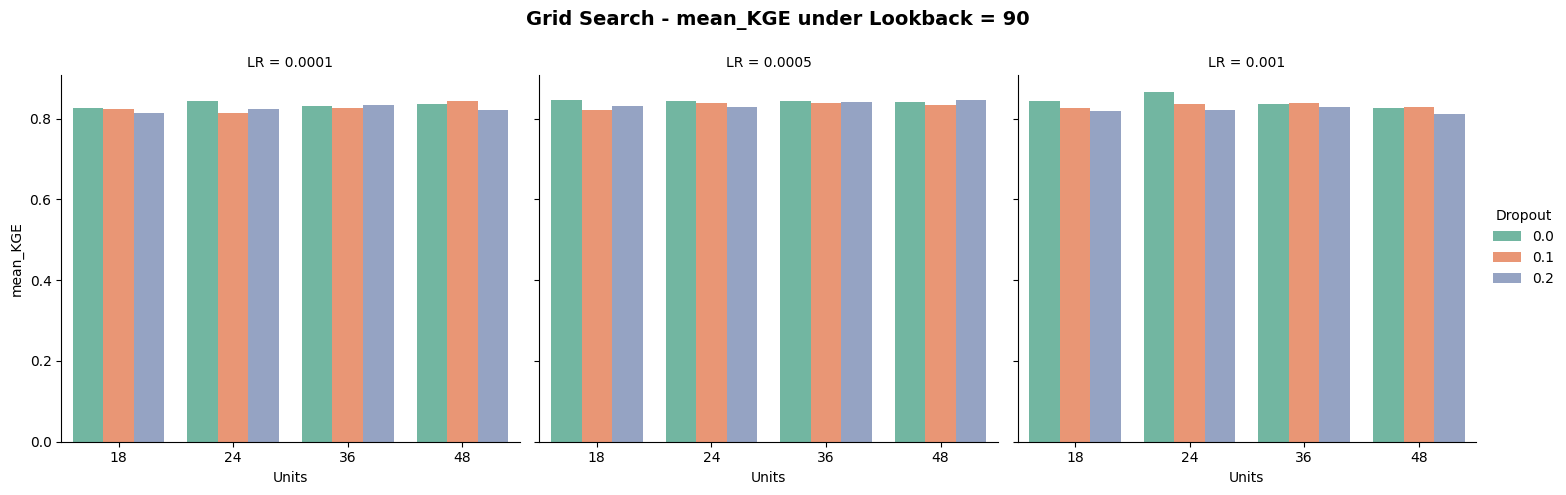

 Barplot saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/barplot_gridsearch_ccc.png


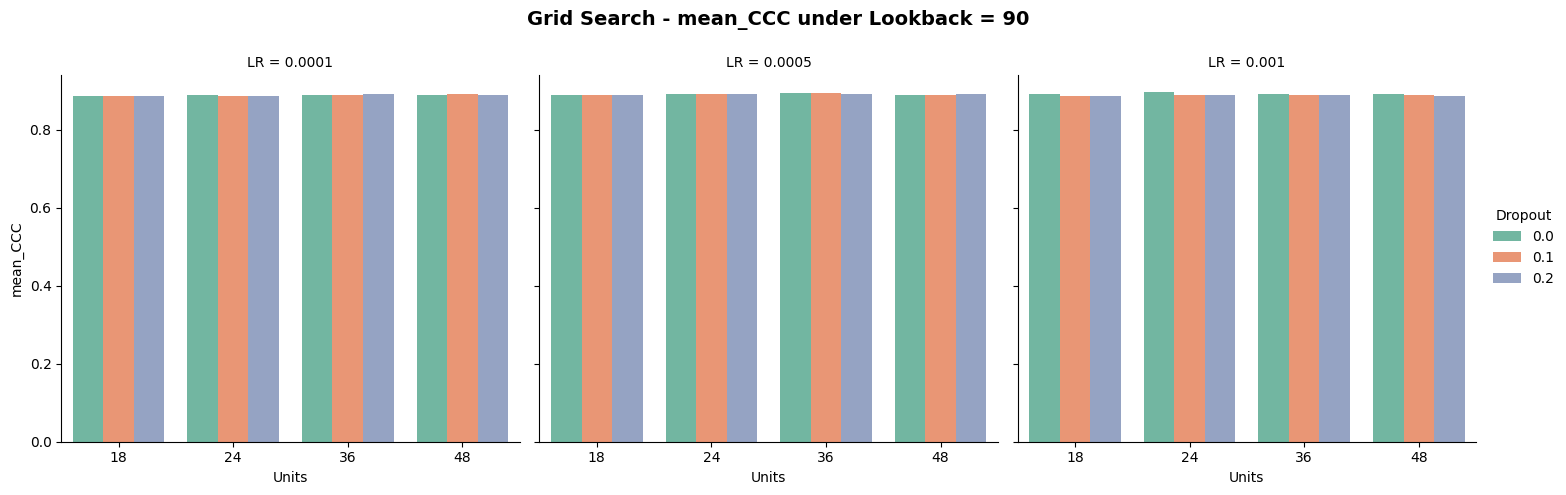

 Barplot saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/barplot_gridsearch_nse.png


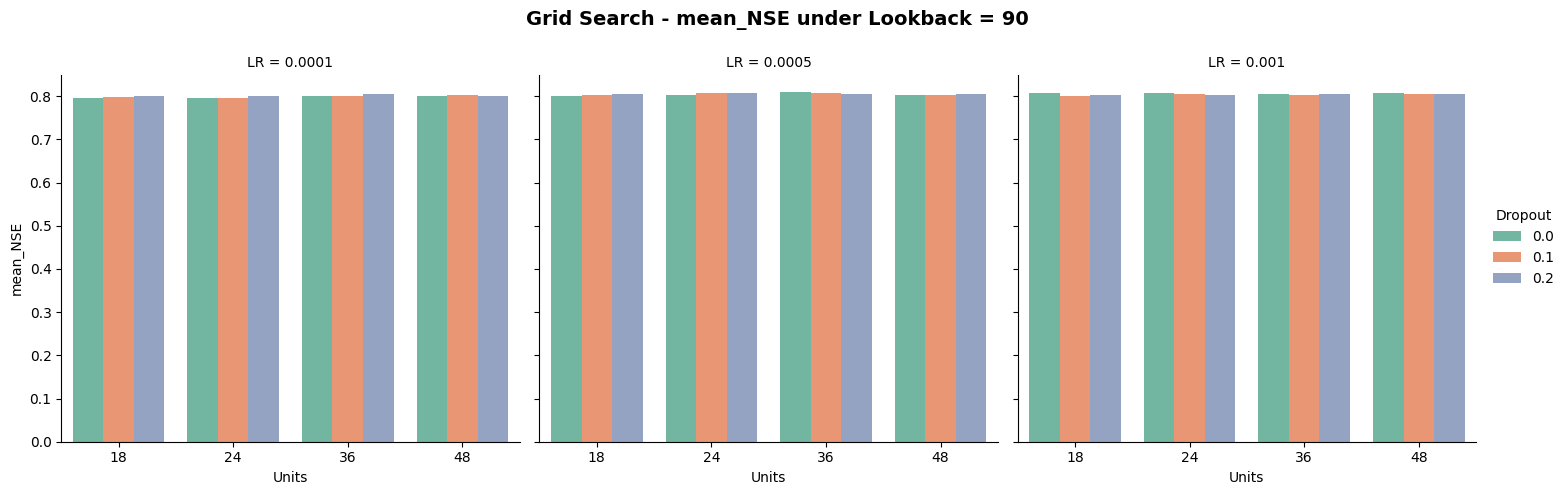

 Best config (for annotation):
lookback    90.000000
units       24.000000
lr           0.001000
dropout      0.000000
mean_KGE     0.865116
std_KGE      0.011386
mean_NSE     0.807710
std_NSE      0.004318
mean_CCC     0.895229
std_CCC      0.003544
Name: 9, dtype: float64


In [43]:
#  Plot mean_KGE barplot

plot_gridsearch_barplots(
    df=df_gridsearch,
    metric="mean_KGE",
    lookback=90,
    save_name=os.path.join(GLOBAL_OUTPUT_DIR, "plots", "barplot_gridsearch_kge.png"))

#  Plot mean_CCC barplot
plot_gridsearch_barplots(
    df=df_gridsearch,
    metric="mean_CCC",
    lookback=90,
    save_name=os.path.join(GLOBAL_OUTPUT_DIR, "plots","barplot_gridsearch_ccc.png")
)
#  Plot mean_CCC barplot
plot_gridsearch_barplots(
    df=df_gridsearch,
    metric="mean_NSE",
    lookback=90,
    save_name=os.path.join(GLOBAL_OUTPUT_DIR,"plots", "barplot_gridsearch_nse.png")
)


# Find the optimal KGE parameter combination
best_row = df_gridsearch.loc[df_gridsearch['mean_KGE'].idxmax()]
print(" Best config (for annotation):")
print(best_row)


In [73]:
best['lookback']

90

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/tmp/ipython-input-376196992.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_kge  = float(he.evaluator(he.kge, y_vl_pred, y_vl)[0])
/tmp/ipython-input-376196992.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_kge = float(he.evaluator(he.kge, y_te_pred, y_te)[0])



 Validation → KGE: 0.8749, NSE: 0.8123, CCC: 0.8987
 Test→ KGE: 0.8437, NSE: 0.8395, CCC: 0.9098


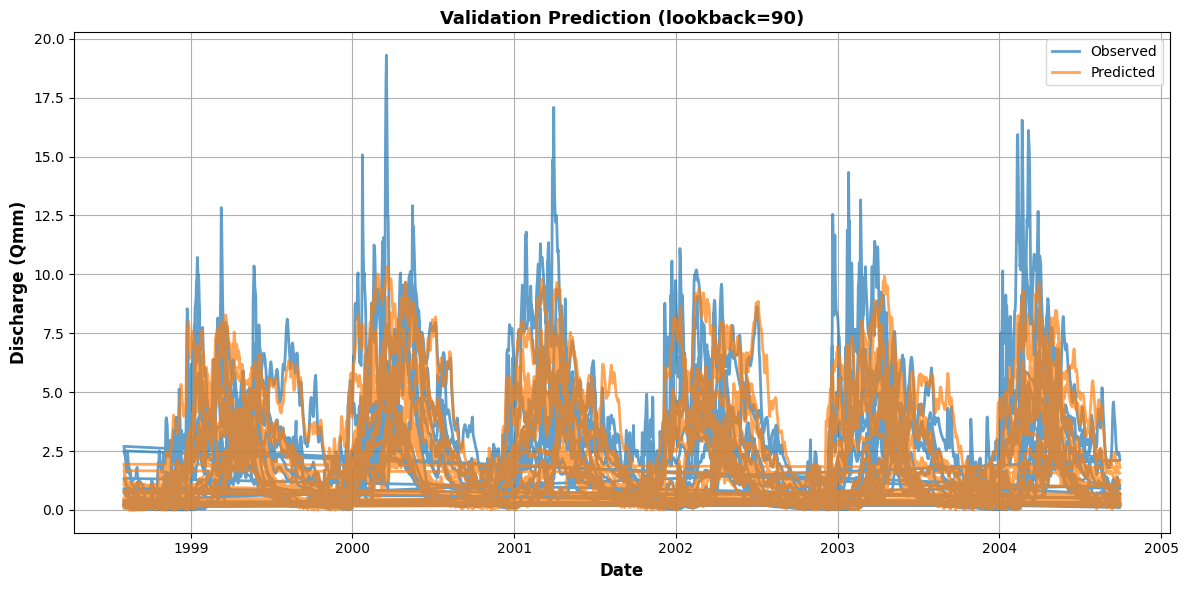

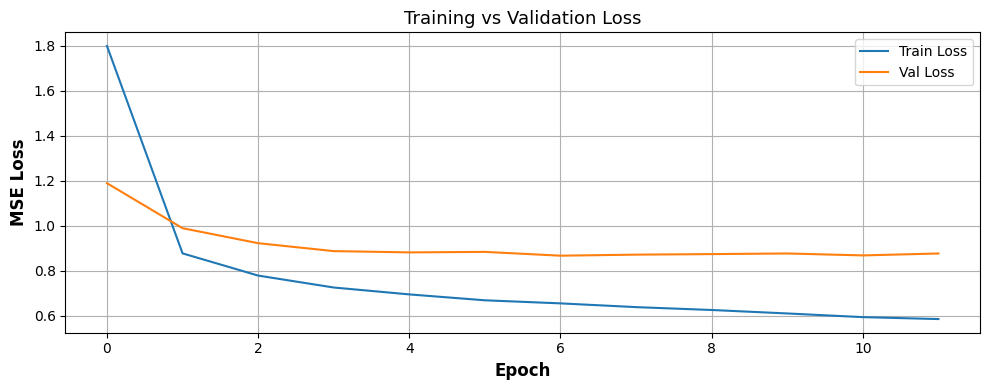


 Final model metrics saved to: /metrics/best_model_metrics_lb90.csv


In [61]:
# Rebuild and load the optimal model
lb    = best['lookback']
units = best['units']
lr    = best['lr']
dp    = best['dropout']

model = make_model(lb, len(ALL_FEATURES), units, dp, lr)
model.load_weights(best_ckpt)

X_tr, y_tr = create_sequences(train_std, ALL_FEATURES, TARGET, lb)
X_vl, y_vl = create_sequences(val_std,   ALL_FEATURES, TARGET, lb)
X_te, y_te = create_sequences(test_std,  ALL_FEATURES, TARGET, lb)


y_vl_pred = model.predict(X_vl).flatten()
y_te_pred = model.predict(X_te).flatten()

val_kge  = float(he.evaluator(he.kge, y_vl_pred, y_vl)[0])
val_nse  = float(he.evaluator(he.nse, y_vl_pred, y_vl)[0])
val_ccc  = concordance_correlation_coefficient(y_vl, y_vl_pred)

test_kge = float(he.evaluator(he.kge, y_te_pred, y_te)[0])
test_nse = float(he.evaluator(he.nse, y_te_pred, y_te)[0])
test_ccc = concordance_correlation_coefficient(y_te, y_te_pred)

print(f"\n Validation → KGE: {val_kge:.4f}, NSE: {val_nse:.4f}, CCC: {val_ccc:.4f}")
print(f" Test→ KGE: {test_kge:.4f}, NSE: {test_nse:.4f}, CCC: {test_ccc:.4f}")


PRED_DIR = os.path.join(GLOBAL_OUTPUT_DIR, "predictions")
os.makedirs(PRED_DIR, exist_ok=True)

np.save(os.path.join(PRED_DIR, f"y_vl_pred_best_lb{lb}.npy"), y_vl_pred)
np.save(os.path.join(PRED_DIR, f"y_te_pred_best_lb{lb}.npy"), y_te_pred)

# Draw the time series comparison chart of the validation set
PLOT_DIR = os.path.join(GLOBAL_OUTPUT_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

dates_vl = val_std['date'].reset_index(drop=True).iloc[lb-1 : lb-1 + len(y_vl)]
plt.figure(figsize=(12,6))
plt.plot(dates_vl, y_vl,      label='Observed', linewidth=2, alpha=0.7)
plt.plot(dates_vl, y_vl_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Date', fontsize=12, fontweight="bold")
plt.ylabel('Discharge (Qmm)', fontsize=12, fontweight="bold")
plt.title(f'Validation Prediction (lookback={lb})', fontsize=13, weight="bold")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, f"val_pred_trend_lb{lb}.png"), dpi=300)
plt.show()

try:
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch', fontsize=12, fontweight="bold")
    plt.ylabel('MSE Loss', fontsize=12, fontweight="bold")
    plt.title('Training vs Validation Loss', fontsize=13)
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"loss_curve_lb{lb}.png"), dpi=300)
    plt.show()
except NameError:
    print(" No history object found. Skipping loss curve plot.")

METRIC_DIR = os.path.join(GLOBAL_OUTPUT_DIR, "metrics")
os.makedirs(METRIC_DIR, exist_ok=True)

df_best_result = pd.DataFrame([{
    'lookback': lb,
    'units': units,
    'lr': lr,
    'dropout': dp,
    'val_KGE': val_kge,
    'val_NSE': val_nse,
    'val_CCC': val_ccc,
    'test_KGE': test_kge,
    'test_NSE': test_nse,
    'test_CCC': test_ccc
}])

df_best_result.to_csv(os.path.join(METRIC_DIR, f"best_model_metrics_lb{lb}.csv"), index=False)
print(f"\n Final model metrics saved to: /metrics/best_model_metrics_lb{lb}.csv")


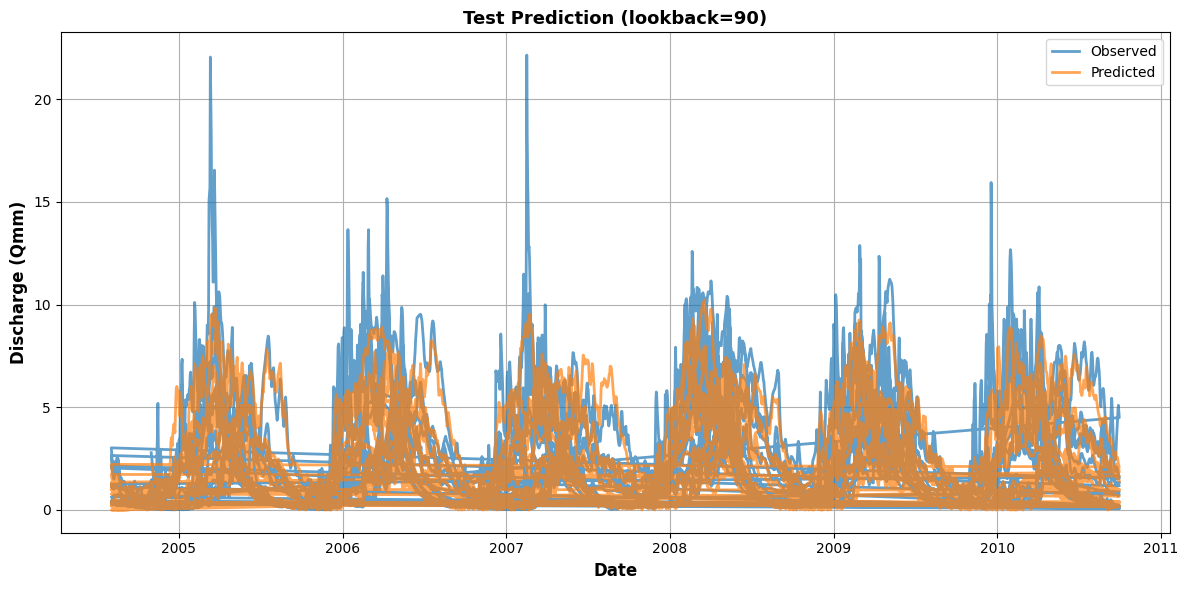

 Test prediction trend saved to: /plots/test_pred_trend_lb90.png


In [62]:
# Plotting Trend Chart of Test Set

dates_te = test_std['date'].reset_index(drop=True).iloc[lb-1 : lb-1 + len(y_te)]
plt.figure(figsize=(12,6))
plt.plot(dates_te, y_te,      label='Observed', linewidth=2, alpha=0.7)
plt.plot(dates_te, y_te_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Date', fontsize=12, fontweight="bold")
plt.ylabel('Discharge (Qmm)', fontsize=12, fontweight="bold")
plt.title(f'Test Prediction (lookback={lb})', fontsize=13, weight="bold")
plt.legend(); plt.grid(True); plt.tight_layout()

# save
plt.savefig(os.path.join(PLOT_DIR, f"test_pred_trend_lb{lb}.png"), dpi=300)
plt.show()

print(f" Test prediction trend saved to: /plots/test_pred_trend_lb{lb}.png")


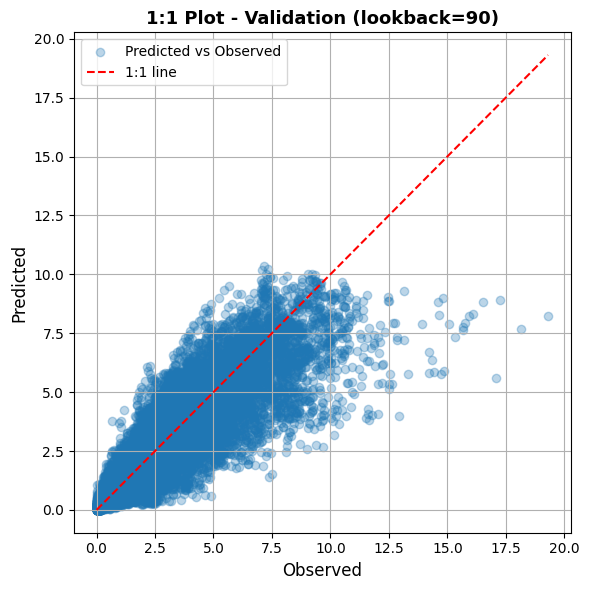

In [63]:
# Validation Set 1: 1:1
plt.figure(figsize=(6,6))
plt.scatter(y_vl, y_vl_pred, alpha=0.3, label='Predicted vs Observed')
plt.plot([y_vl.min(), y_vl.max()], [y_vl.min(), y_vl.max()], 'r--', label='1:1 line')
plt.xlabel("Observed", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.title(f"1:1 Plot - Validation (lookback={lb})", fontsize=13, weight='bold')
plt.legend(); plt.grid(True); plt.tight_layout()

plt.savefig(os.path.join(PLOT_DIR, f"scatter_1to1_validation_lb{lb}.png"), dpi=300)
plt.show()


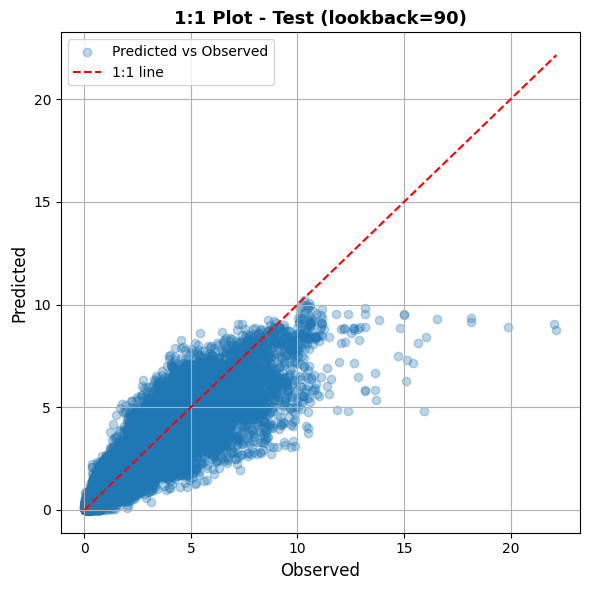

In [64]:
# Test Set 1: 1:1
plt.figure(figsize=(6,6))
plt.scatter(y_te, y_te_pred, alpha=0.3, label='Predicted vs Observed')
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--', label='1:1 line')
plt.xlabel("Observed", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.title(f"1:1 Plot - Test (lookback={lb})", fontsize=13, weight='bold')
plt.legend(); plt.grid(True); plt.tight_layout()

plt.savefig(os.path.join(PLOT_DIR, f"scatter_1to1_test_lb{lb}.png"), dpi=300)
plt.show()

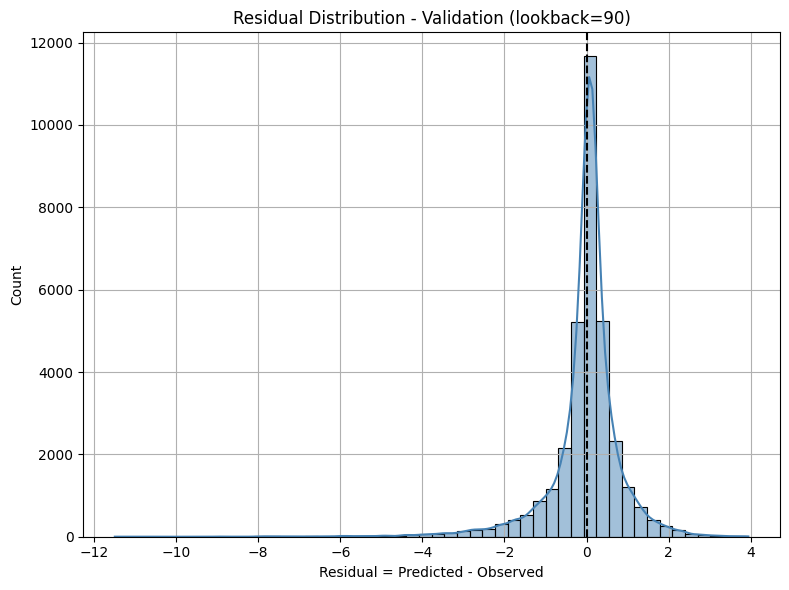

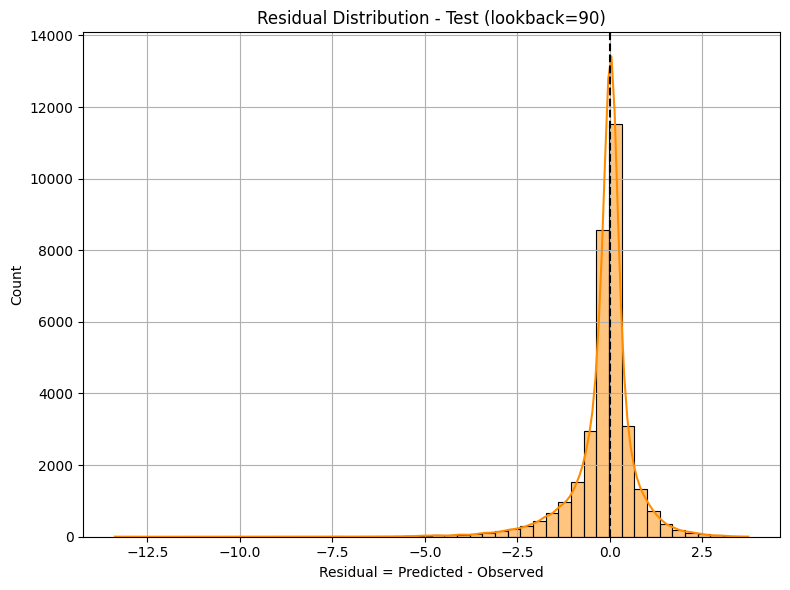

In [65]:
#Calculate the residuals
residuals_val = y_vl_pred - y_vl
residuals_test = y_te_pred - y_te

# Validation set residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals_val, kde=True, bins=50, color='steelblue')
plt.axvline(0, color='black', linestyle='--')
plt.title(f"Residual Distribution - Validation (lookback={lb})")
plt.xlabel("Residual = Predicted - Observed"); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, f"residual_hist_val_lb{lb}.png"), dpi=300)
plt.show()

# Test set residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals_test, kde=True, bins=50, color='darkorange')
plt.axvline(0, color='black', linestyle='--')
plt.title(f"Residual Distribution - Test (lookback={lb})")
plt.xlabel("Residual = Predicted - Observed"); plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, f"residual_hist_test_lb{lb}.png"), dpi=300)
plt.show()


In [74]:
#Sliding window + Prediction (based on best['lookback'] = 90)
X_vl_vis, y_val_vis = create_sequences(val_std, ALL_FEATURES, TARGET, lb)
y_vl_pred_vis = model.predict(X_vl_vis).flatten()

val_basin_ids_vis = val_std['ID_CABra'].reset_index(drop=True).iloc[lb-1 : lb-1 + len(y_val_vis)]
val_dates_vis     = val_std['date'].reset_index(drop=True).iloc[lb-1 : lb-1 + len(y_val_vis)]

# Check for consistency
print(len(X_vl_vis), len(y_val_vis), len(y_vl_pred_vis), len(val_basin_ids_vis), len(val_dates_vis))



1053/1053 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
33676 33676 33676 33676 33676


In [81]:
# General drawing function
def plot_single_basin_trend(basin_id, y_true, y_pred, id_seq, date_seq, split="val"):
    mask = (id_seq == basin_id)
    if np.sum(mask) == 0:
        print(f" Basin {basin_id} has no data in {split} set.")
        return

    dates_basin = date_seq[mask]
    obs_basin   = y_true[mask]
    pred_basin  = y_pred[mask]

    plt.figure(figsize=(10,4))
    plt.plot(dates_basin, obs_basin, label="Observed", linewidth=2)
    plt.plot(dates_basin, pred_basin, label="Predicted", linewidth=2, alpha=0.7)
    #plt.title(f"{split.title()} Prediction - Basin {basin_id} (LB={lb})", fontsize=13)
    plt.xlabel("Date"); plt.ylabel("Discharge (Qmm)")
    plt.legend(); plt.grid(True); plt.tight_layout()

    save_path = os.path.join(PLOT_DIR, f"{split}_trend_basin{basin_id}_lb{lb}.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f" Saved: {save_path}")


In [82]:
for bid in basin_ids:
    plot_single_basin_trend(
        basin_id=bid,
        y_true=y_val_vis,
        y_pred=y_vl_pred_vis,
        id_seq=val_basin_ids_vis,
        date_seq=val_dates_vis,
        split="val"
    )


 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin11_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin21_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin22_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin30_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin31_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin32_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin35_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin37_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin42_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_trend_basin44_lb90.png
 Saved: /content/drive/MyDrive

In [79]:

X_te_vis, y_test_vis = create_sequences(test_std, ALL_FEATURES, TARGET, lb)
y_te_pred_vis = model.predict(X_te_vis).flatten()


test_basin_ids_vis = test_std['ID_CABra'].reset_index(drop=True).iloc[lb-1 : lb-1 + len(y_test_vis)]
test_dates_vis     = test_std['date'].reset_index(drop=True).iloc[lb-1 : lb-1 + len(y_test_vis)]


assert len(y_test_vis) == len(y_te_pred_vis) == len(test_basin_ids_vis) == len(test_dates_vis), "Test set variable lengths are inconsistent!"


1052/1052 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [83]:
for bid in basin_ids:
    plot_single_basin_trend(
        basin_id=bid,
        y_true=y_test_vis,
        y_pred=y_te_pred_vis,
        id_seq=test_basin_ids_vis,
        date_seq=test_dates_vis,
        split="test"
    )


 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin11_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin21_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin22_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin30_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin31_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin32_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin35_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin37_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin42_lb90.png
 Saved: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/test_trend_basin44_lb90.png
 Saved: /content/dri

In [88]:
def plot_val_test_comparison(basin_id, lb):
    #mask
    mask_val = val_basin_ids_vis == basin_id
    mask_test = test_basin_ids_vis == basin_id

    if np.sum(mask_val) == 0 or np.sum(mask_test) == 0:
        print(f" Basin {basin_id} Unable to find data in validation or test set")
        return

    # data
    dates_val = val_dates_vis[mask_val]
    obs_val = y_val_vis[mask_val]
    pred_val = y_vl_pred_vis[mask_val]

    dates_test = test_dates_vis[mask_test]
    obs_test = y_test_vis[mask_test]
    pred_test = y_te_pred_vis[mask_test]

    # plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharey=True)

    axes[0].plot(dates_val, obs_val, label='Observed', linewidth=2)
    axes[0].plot(dates_val, pred_val, label='Predicted', linewidth=2, alpha=0.7)
    axes[0].set_title(f'Validation Prediction - Basin {basin_id} (LB={lb})', fontsize=13)
    axes[0].legend(); axes[0].grid(True)

    axes[1].plot(dates_test, obs_test, label='Observed', linewidth=2)
    axes[1].plot(dates_test, pred_test, label='Predicted', linewidth=2, alpha=0.7)
    axes[1].set_title(f'Test Prediction - Basin {basin_id} (LB={lb})', fontsize=13)
    axes[1].legend(); axes[1].grid(True)

    fig.suptitle(f"Basin {basin_id} - Validation & Test Trend", fontsize=14, weight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    # save
    save_path = os.path.join(PLOT_DIR, f"val_test_trend_basin{basin_id}_lb{lb}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f" Have saved {save_path}")


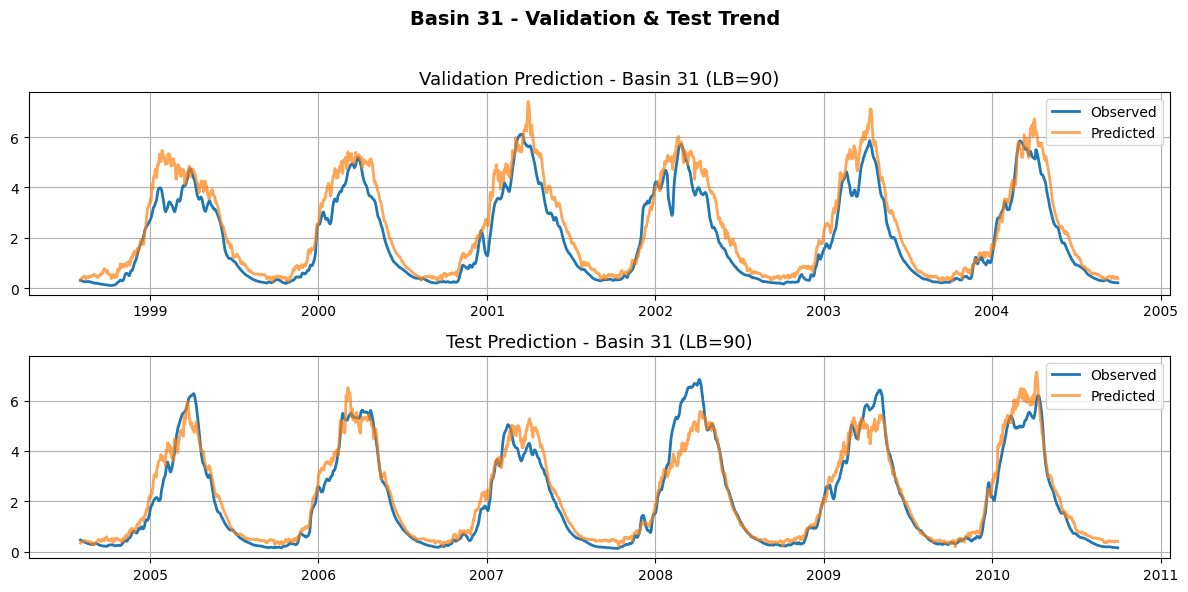

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin31_lb90.png


In [89]:
plot_val_test_comparison(basin_id=31, lb=best['lookback'])

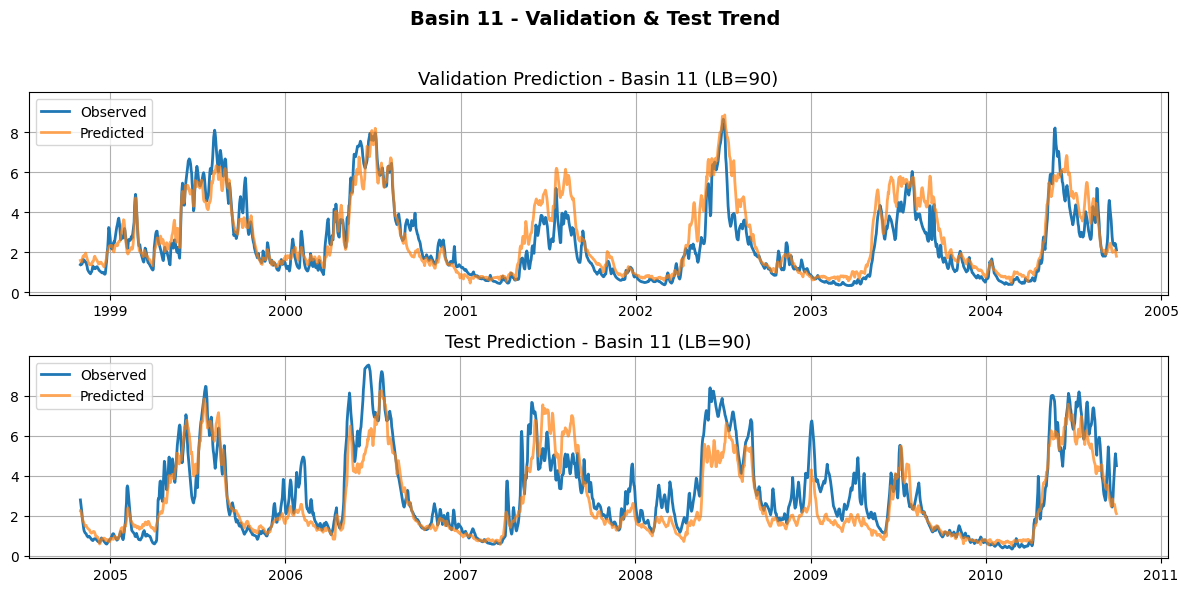

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin11_lb90.png


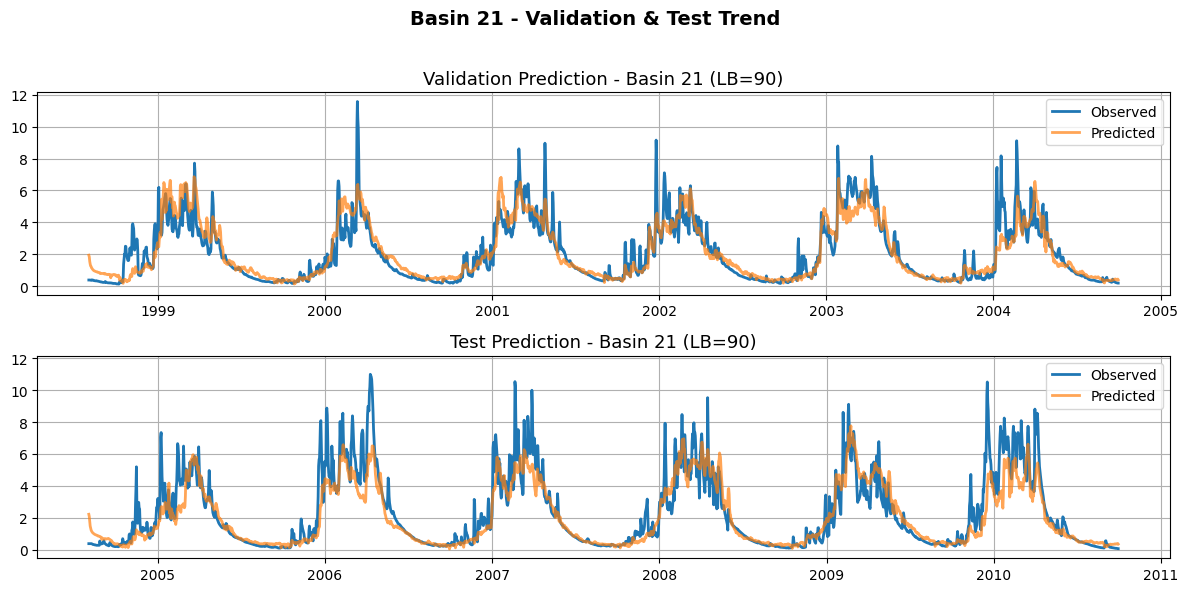

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin21_lb90.png


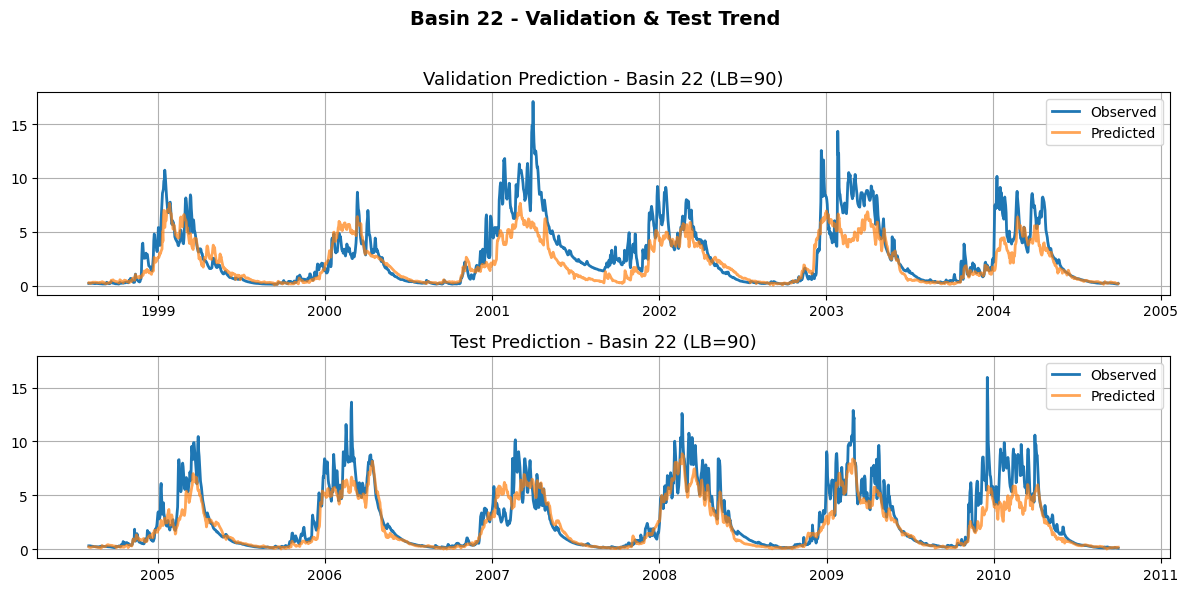

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin22_lb90.png


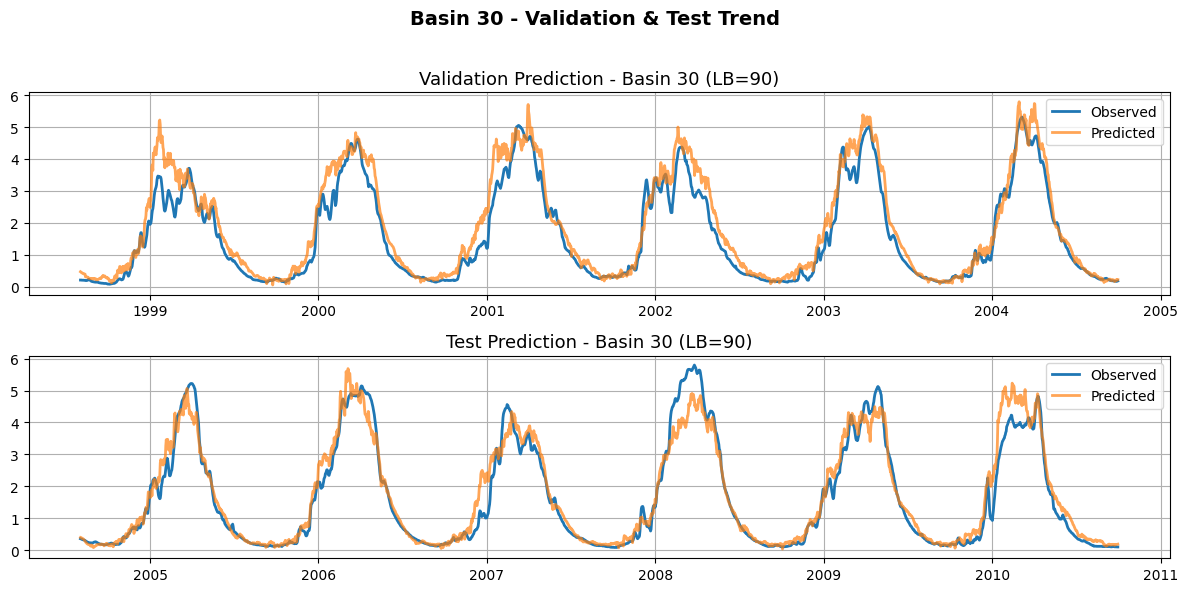

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin30_lb90.png


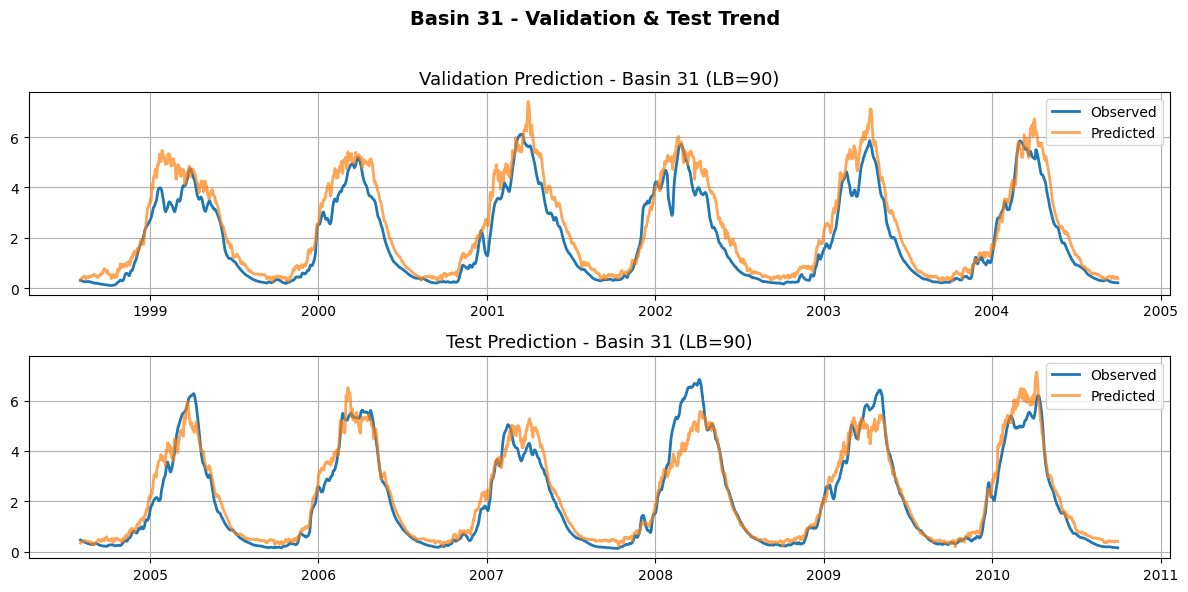

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin31_lb90.png


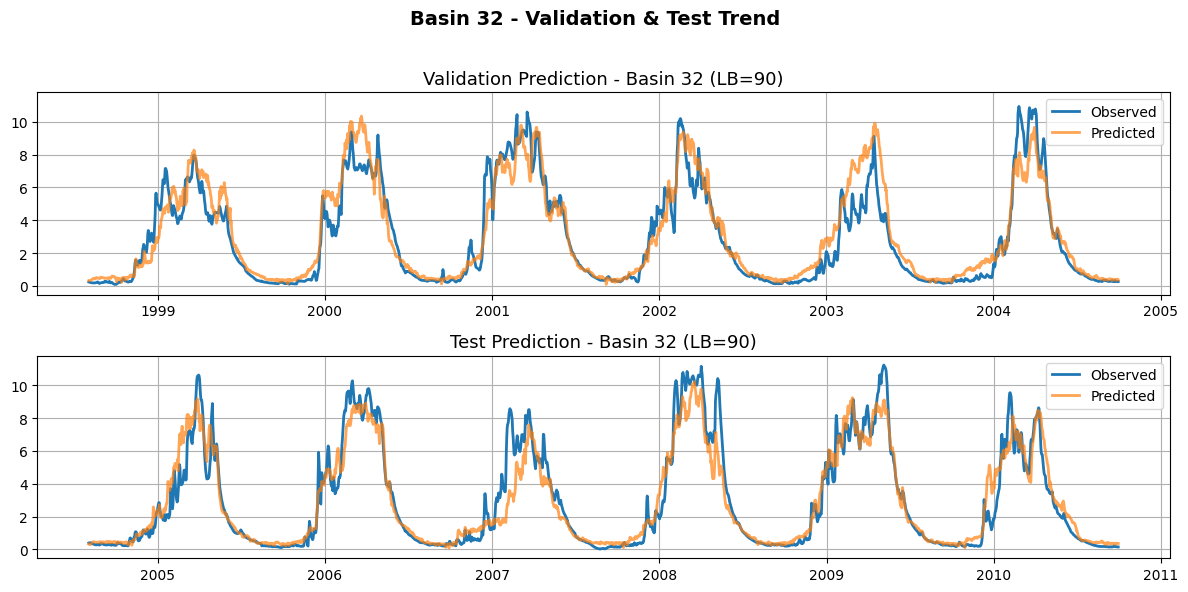

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin32_lb90.png


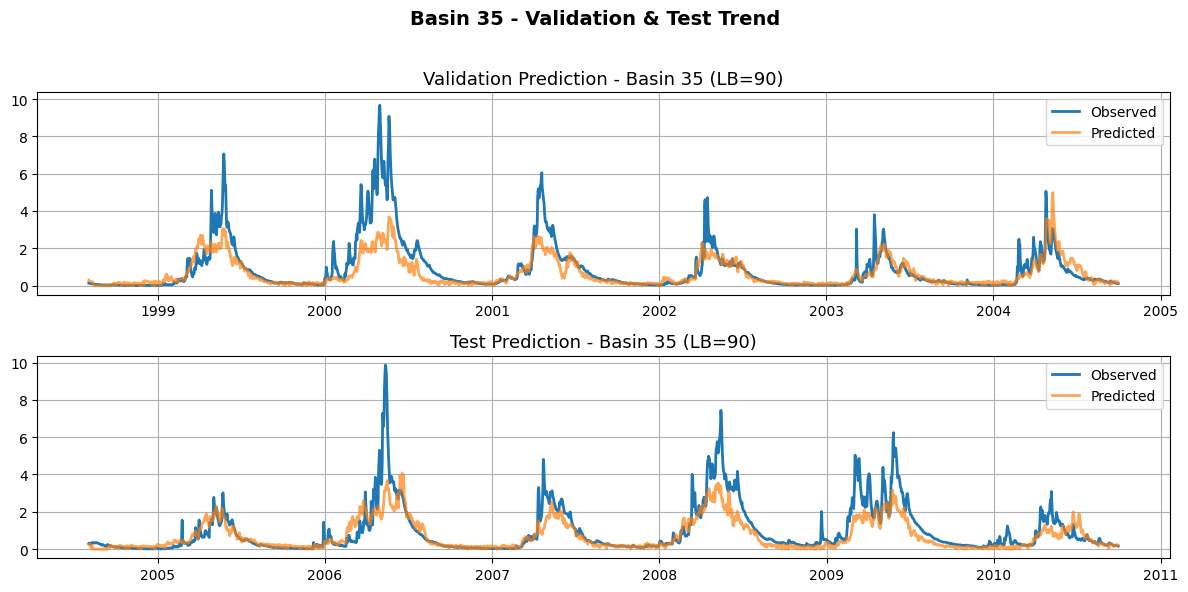

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin35_lb90.png


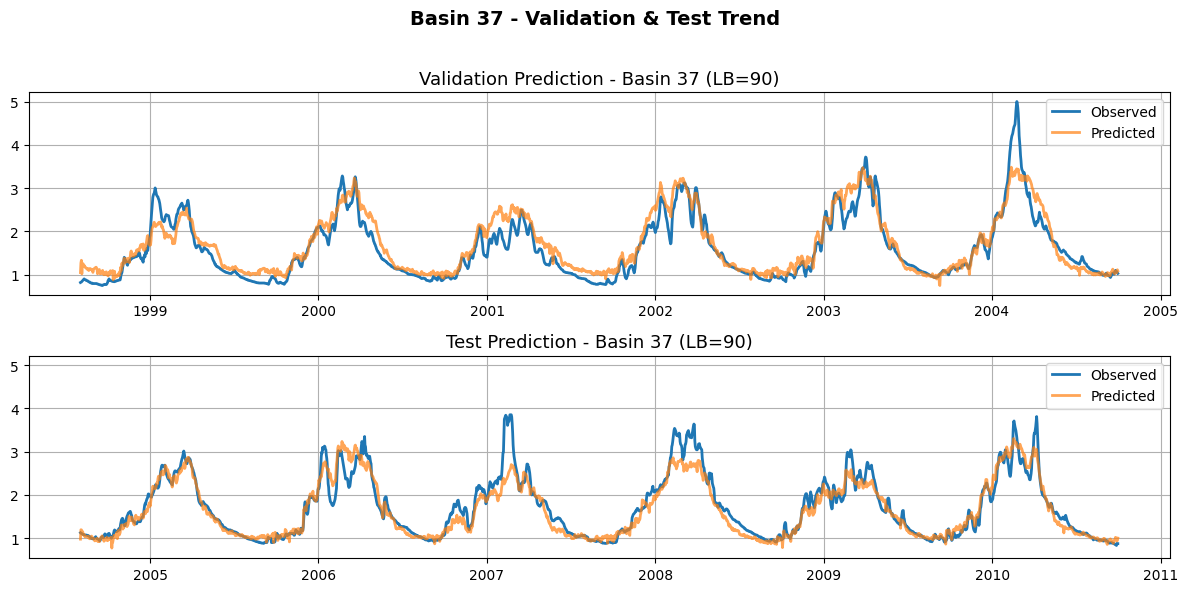

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin37_lb90.png


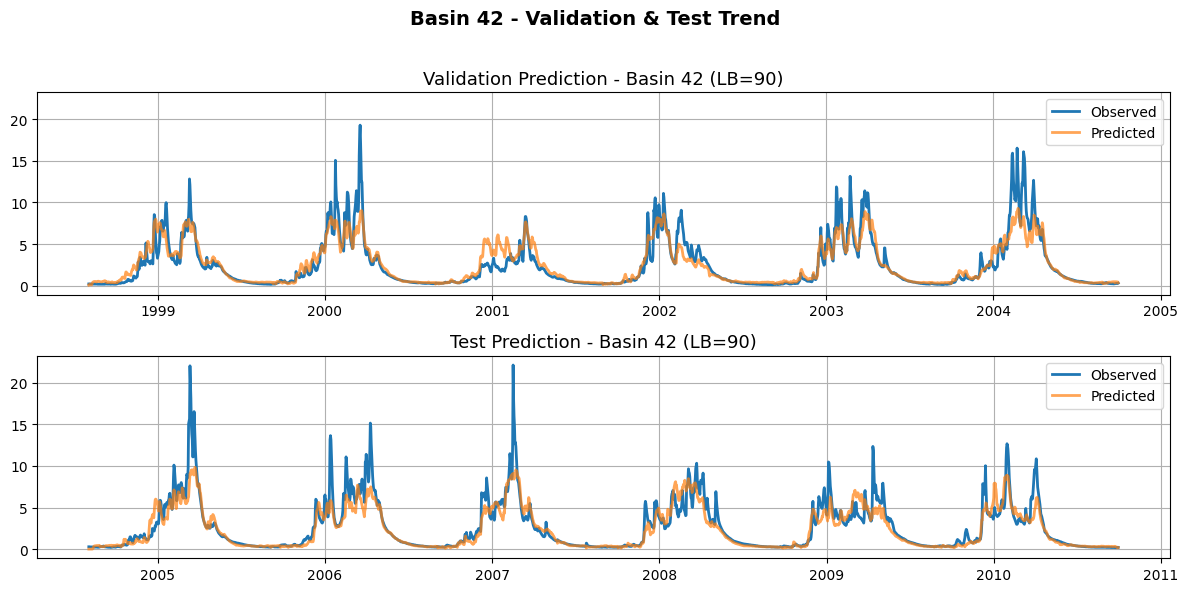

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin42_lb90.png


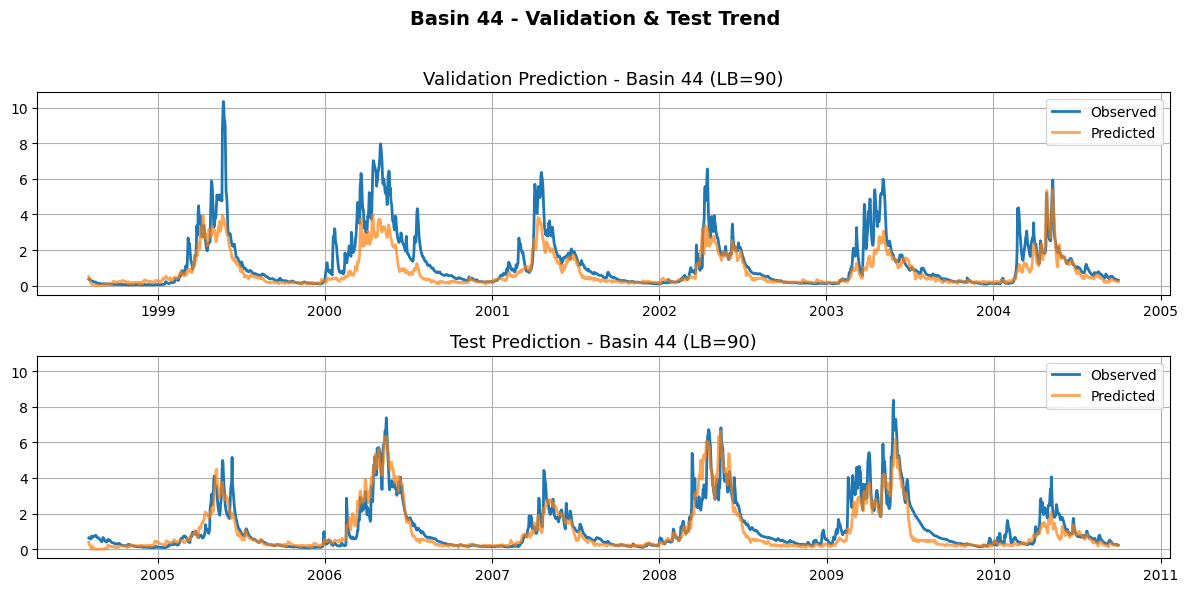

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin44_lb90.png


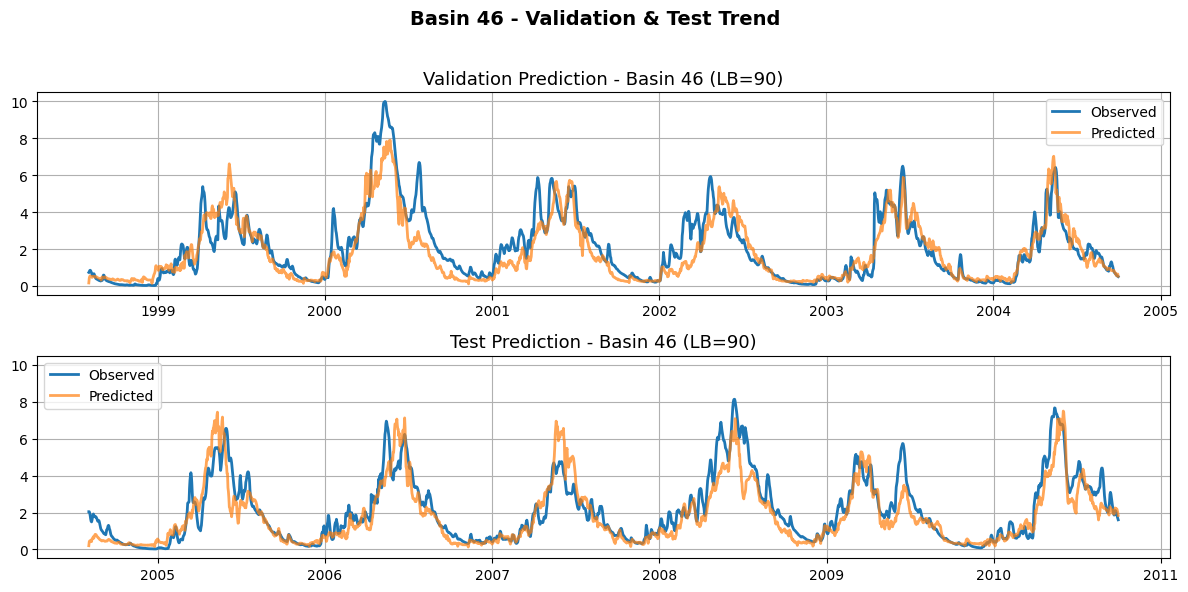

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin46_lb90.png


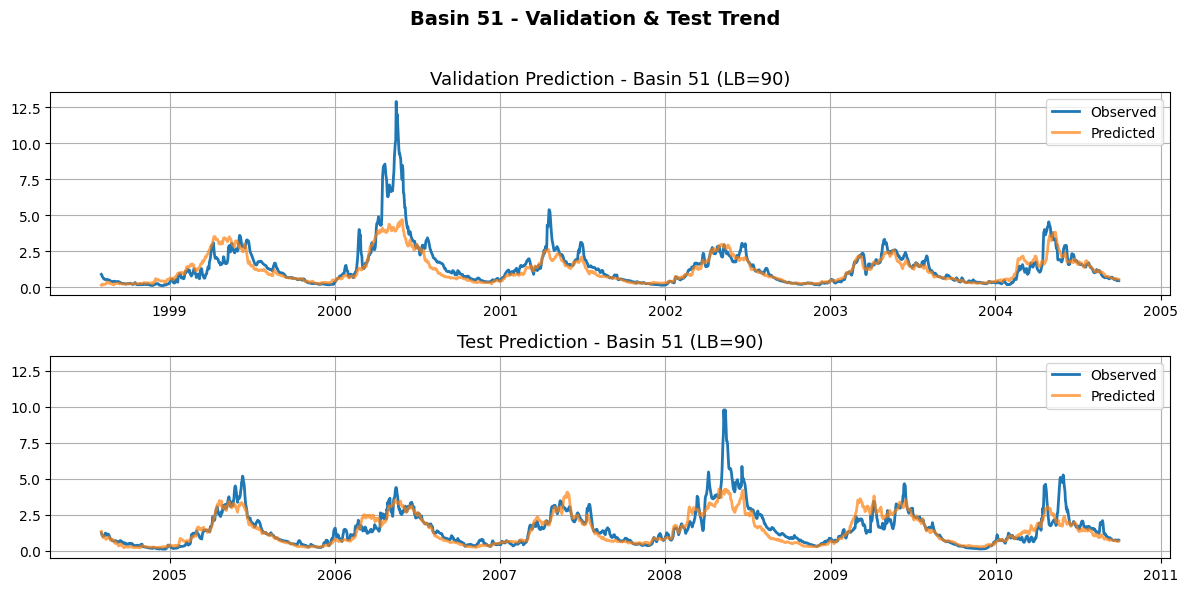

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin51_lb90.png


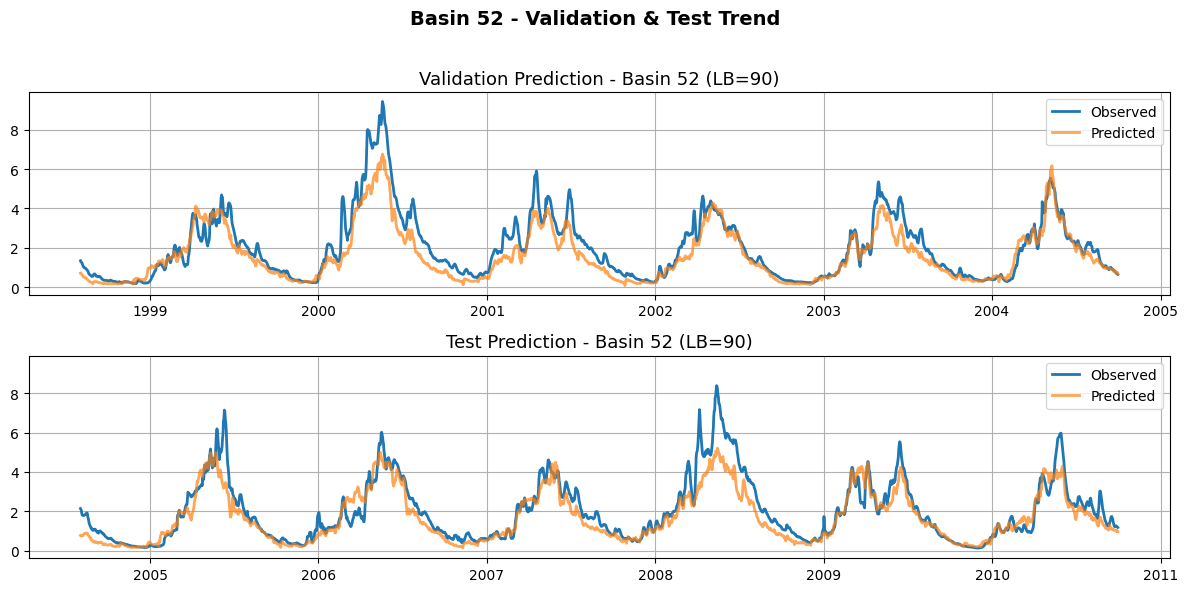

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin52_lb90.png


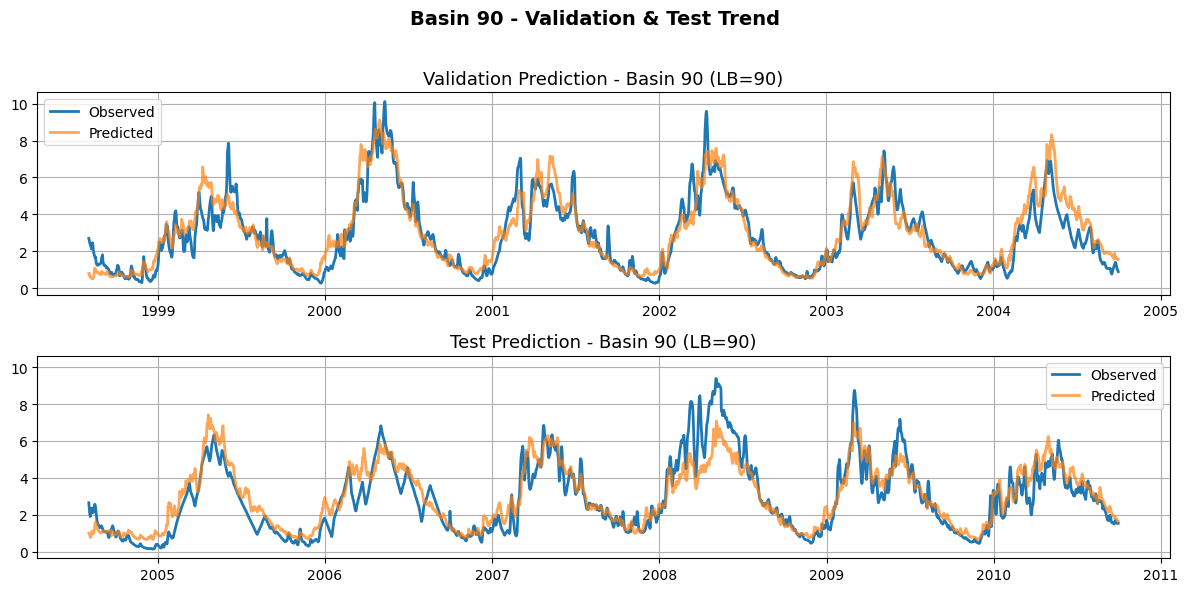

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin90_lb90.png


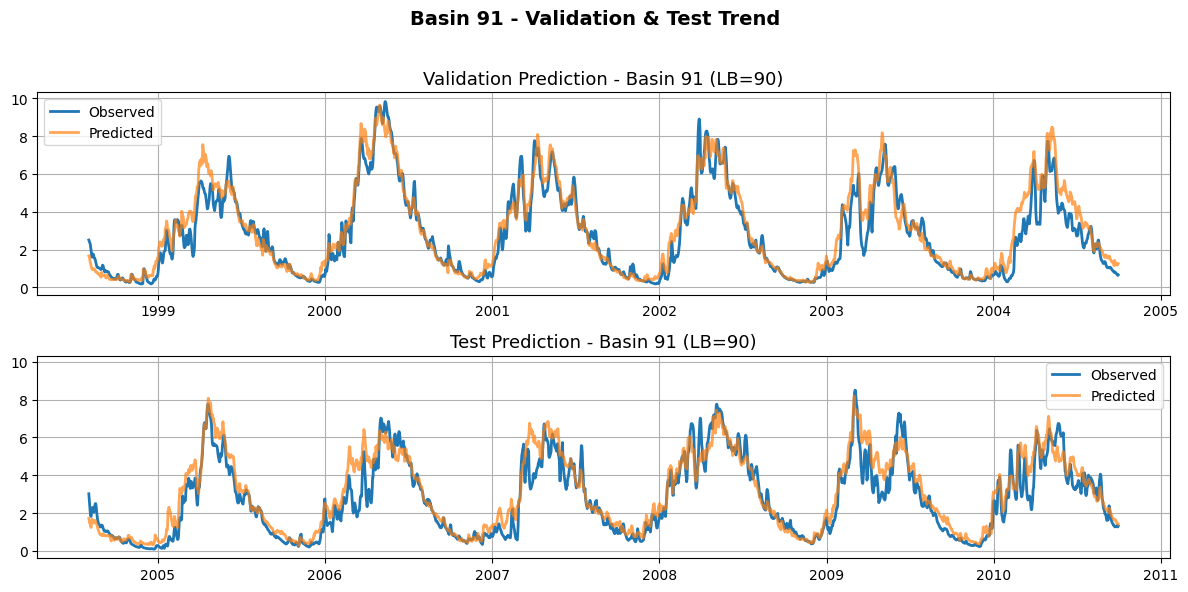

 Have saved /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/plots/val_test_trend_basin91_lb90.png


In [90]:
for bid in basin_ids:
    plot_val_test_comparison(basin_id=bid, lb=best['lookback'])

In [84]:
from hydroeval import evaluator, kge, nse

results = []

def compute_basin_metrics(basin_id, y_true, y_pred, id_seq, dataset_name="val"):
    mask = (id_seq == basin_id)
    if np.sum(mask) == 0:
        print(f" Basin {basin_id} has no data in {dataset_name} set.")
        return None

    true_basin = y_true[mask]
    pred_basin = y_pred[mask]

    kge_val = float(np.atleast_1d(evaluator(kge, pred_basin, true_basin))[0])
    nse_val = float(np.atleast_1d(evaluator(nse, pred_basin, true_basin))[0])
    ccc_val = concordance_correlation_coefficient(true_basin, pred_basin)

    results.append({
        "Basin_ID": basin_id,
        "Set": dataset_name,
        "KGE": kge_val,
        "NSE": nse_val,
        "CCC": ccc_val
    })


In [85]:
#Validation set metrics
for bid in basin_ids:
    compute_basin_metrics(
        basin_id=bid,
        y_true=y_val_vis,
        y_pred=y_vl_pred_vis,
        id_seq=val_basin_ids_vis,
        dataset_name="val"
    )

# Test set metrics
for bid in basin_ids:
    compute_basin_metrics(
        basin_id=bid,
        y_true=y_test_vis,
        y_pred=y_te_pred_vis,
        id_seq=test_basin_ids_vis,
        dataset_name="test"
    )


/tmp/ipython-input-3050028177.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kge_val = float(np.atleast_1d(evaluator(kge, pred_basin, true_basin))[0])


In [87]:
df_metrics = pd.DataFrame(results)
csv_path = os.path.join(GLOBAL_OUTPUT_DIR, "metrics", f"per_basin_KGE_NSE_CCC_lb{lb}.csv")
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
df_metrics.to_csv(csv_path, index=False)
print(f" Metrics saved to: {csv_path}")


 Metrics saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/metrics/per_basin_KGE_NSE_CCC_lb90.csv


In [93]:
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "X_val.npy"), X_vl)
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "y_val.npy"), y_vl)
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "X_test.npy"), X_te)
np.save(os.path.join(GLOBAL_OUTPUT_DIR, "y_test.npy"), y_te)

In [92]:
import json
with open("best_config.json", "w") as f:
    json.dump(best, f)

# 3.Integrated Gradients

In [94]:
X_ig, _ = create_sequences(val_std, ALL_FEATURES, TARGET, LOOKBACK)

In [95]:
def interpolate_inputs(baseline, input, alpha):
    return baseline + alpha * (input - baseline)

def compute_gradients(model, inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
    return tape.gradient(predictions, inputs)

def integrated_gradients_single(model, baseline, input_tensor, m_steps=50):
    alphas = tf.linspace(0.0, 1.0, m_steps)
    integrated_grads = tf.zeros_like(input_tensor, dtype=tf.float32)
    for alpha in alphas:
        interpolated = interpolate_inputs(baseline, input_tensor, alpha)
        grads = compute_gradients(model, interpolated)
        integrated_grads += grads / m_steps
    return (input_tensor - baseline) * integrated_grads

def compute_integrated_gradients_all(model, X_input, feature_names,
                                     baseline_type="zero", m_steps=50,
                                     save_csv_path=None, plot=True):
    """
    Perform IG analysis on the entire sample set and output the variable importance matrix (lookback × features)
    """

    assert X_input.ndim == 3, "X_input must be 3D (samples, lookback, features)"
    assert len(feature_names) == X_input.shape[2], "Feature name count mismatch"

    print(" Running Integrated Gradients...")

    if baseline_type == "mean":
        baseline = tf.convert_to_tensor(np.mean(X_input, axis=0, keepdims=True), dtype=tf.float32)
    else:
        baseline = tf.zeros_like(X_input[0:1], dtype=tf.float32)

    all_importances = []
    for i in tqdm(range(len(X_input)), desc=" IG computing"):
        input_tensor = tf.convert_to_tensor(X_input[i:i+1], dtype=tf.float32)
        ig_tensor = integrated_gradients_single(model, baseline, input_tensor, m_steps)
        all_importances.append(ig_tensor.numpy().squeeze(0))

    all_importances = np.array(all_importances)
    mean_importance = np.mean(np.abs(all_importances), axis=0)
    print(" IG shape:", mean_importance.shape)

    df_importance = pd.DataFrame(mean_importance, columns=feature_names)

    if save_csv_path:
        os.makedirs(os.path.dirname(save_csv_path), exist_ok=True)
        df_importance.to_csv(save_csv_path, index=False)
        print(f" Saved IG matrix to: {save_csv_path}")

    if plot:
        # Bar chart (average importance)
        plt.figure(figsize=(10, 6))
        df_importance.mean().sort_values().plot(kind='barh', color='#4da6ff')
        plt.title("Mean IG Feature Importance", fontsize=13, weight='bold')
        plt.xlabel("Mean IG Score")
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        if save_csv_path:
            plt.savefig(save_csv_path.replace(".csv", "_barh.png"), dpi=300)
        plt.show()

        # Bar chart (average importance)
        plt.figure(figsize=(10, 6))
        plt.imshow(mean_importance.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='IG Importance')
        plt.yticks(np.arange(len(feature_names)), feature_names)
        plt.xlabel("Timestep")
        plt.title("IG Heatmap (time × feature)", fontsize=13, weight='bold')
        plt.tight_layout()
        if save_csv_path:
            plt.savefig(save_csv_path.replace(".csv", "_heatmap.png"), dpi=300)
        plt.show()

    return df_importance

In [97]:
#Set the output path
SAVE_DIR = os.path.join(GLOBAL_OUTPUT_DIR, "interpret_ig")
os.makedirs(SAVE_DIR, exist_ok=True)
save_csv_path = os.path.join(SAVE_DIR,  f"IG_matrix_fast_lb{LOOKBACK}.csv")

 Running Integrated Gradients...


 IG computing: 100%|██████████| 5000/5000 [34:30<00:00,  2.42it/s]


 IG shape: (90, 18)
 Saved IG matrix to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/interpret_ig/IG_matrix_fast_lb90.csv


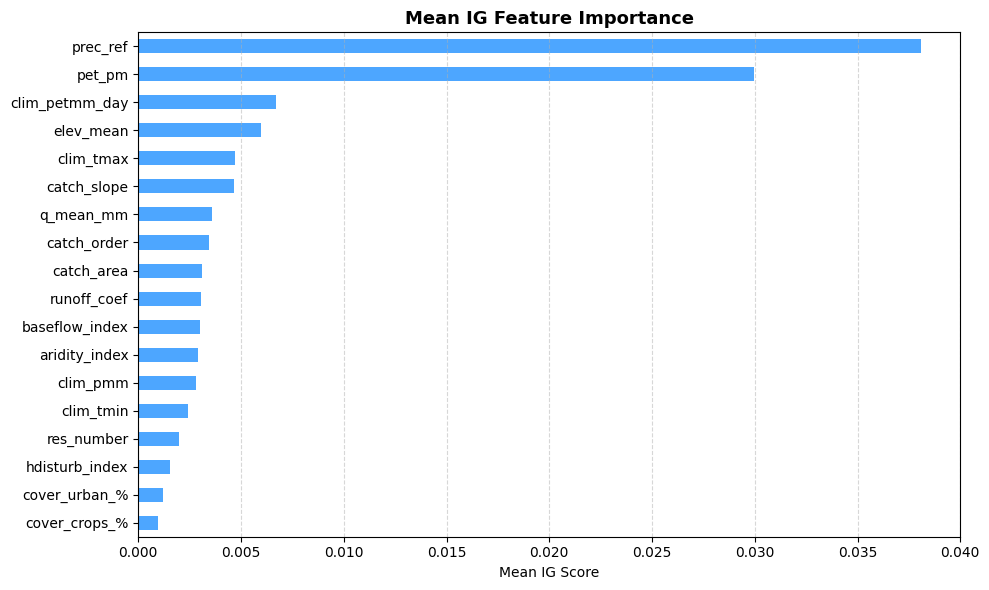

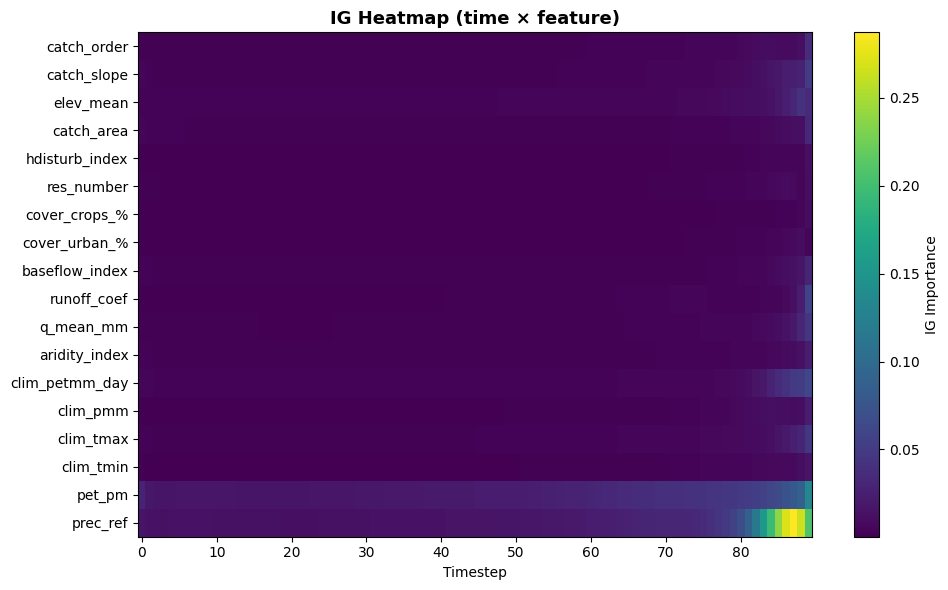

In [98]:
# Subset sampling (first 5000 validation samples)
X_ig_short = X_ig[:5000]

ig_result_df = compute_integrated_gradients_all(
    model=model,
    X_input=X_ig_short,
    feature_names=ALL_FEATURES,
    baseline_type="zero",        
    m_steps=20,                   
    save_csv_path=save_csv_path,
    plot=True
)

In [99]:
#Time trend chart
def plot_ig_trends(df_ig, selected_features=None, save_path=None, title="IG Importance over Timesteps"):
    """
    Draw the average contribution trend curve of each feature of the integrated gradient at different time steps
    """
    plt.figure(figsize=(12, 6))

    if selected_features is None:
        selected_features = df_ig.columns.tolist()

    for feat in selected_features:
        plt.plot(df_ig[feat], label=feat)

    plt.xlabel("Timestep (from past → now)", fontsize=12)
    plt.ylabel("IG Importance", fontsize=12)
    plt.title(title, fontsize=13, weight='bold')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f" IG trend plot saved to: {save_path}")

    plt.show()

 IG trend plot saved to: /content/drive/MyDrive/Colab Notebooks/lstm_outputs_new/interpret_ig/IG_matrix_fast_lb90_trend.png


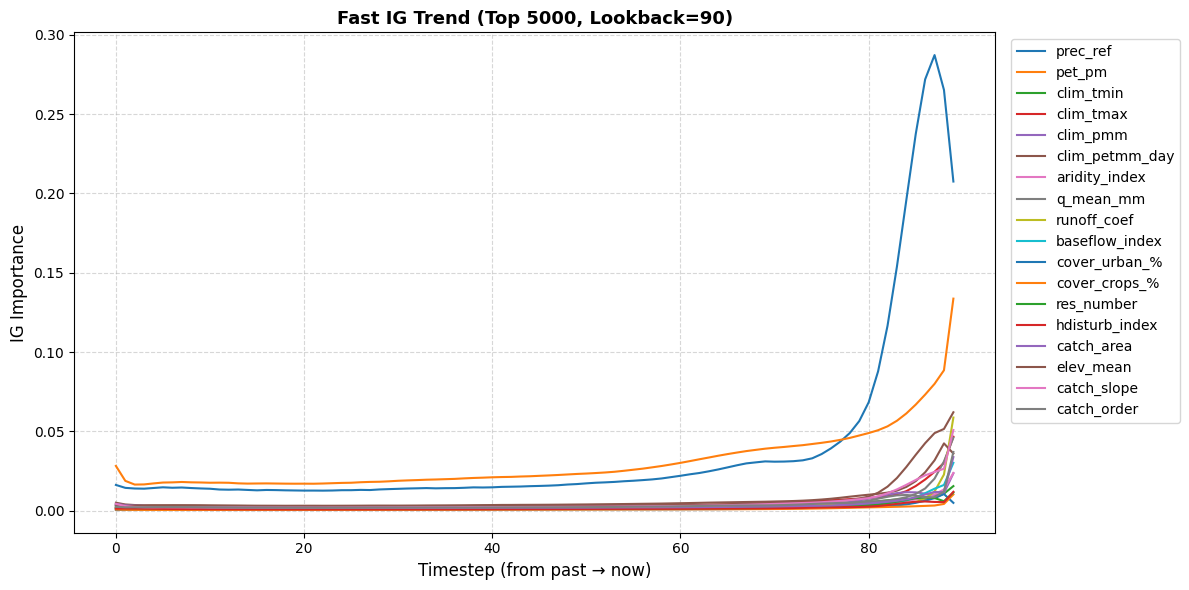

In [100]:
plot_ig_trends(
    df_ig=ig_result_df,
    selected_features=ALL_FEATURES,
    save_path=save_csv_path.replace(".csv", "_trend.png"),
    title=f"Fast IG Trend (Top 5000, Lookback={LOOKBACK})"
)
